# Verschiedene Clustering Methods
## Daten Vorbereitung und Vorverarbeitung
### Bibliotheken importieren

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset importiert

In [3]:
df = pd.read_csv('user_data.csv')

### Postleitzahl validieren


In [4]:
def is_valid_zip(zip_code):
    return re.match(r'^\d{5}$', str(zip_code)) is not None
df['user_zip'] = df['user_zip'].apply(lambda x: x if is_valid_zip(x) else None)

In [5]:
# Daten aus 'zip.csv' laden und für den Merge vorbereiten
zip_df = pd.read_csv('zip.csv', delimiter=';', encoding='latin-1')
zip_df = zip_df[['Plz', 'Bundesland']]
zip_df.columns = ['user_zip', 'Bundesland']

# Doppelte Einträge in 'zip_df' basierend auf der 'user_zip' Spalte entfernen
zip_df = zip_df.drop_duplicates(subset=['user_zip'])

# 'user_zip' Spalte in beiden DataFrames in String konvertieren
df['user_zip'] = df['user_zip'].astype(str)
zip_df['user_zip'] = zip_df['user_zip'].astype(str)

# Die beiden DataFrames zusammenführen
df = df.merge(zip_df, on='user_zip', how='left')

# 'user_zip' Spalte entfernen
df.drop(columns=['user_zip'], inplace=True)

In [6]:
df.head()

user_email  frequency_purchases  number_suppliers   
0            007bunny@online.de                   10                 1  \
1       01721569373@vodafone.de                    1                 1   
2      017663067537@o2online.de                    1                 2   
3  05-parodien-fahrt@icloud.com                    1                 1   
4              112303888@qq.com                    1                 1   

   total_purchase_amount  total_products_purchases  unique_articles_purchased   
0                1264.61                        25                         12  \
1                  37.20                         2                          1   
2                 132.66                         2                          2   
3                  95.78                         2                          2   
4                  81.51                         3                          1   

   average_discount  coupons_used  top_supplier_percetage   
0              0.16             7                    0.41  \
1              0.76             0                    1.00   
2              0.54             0                    0.85   
3              0.51             0                    1.00   
4              0.45             0                    1.00   

   average_purchase_value  percent_desktop user_salutation   
0                 126.461              0.2              ms  \
1                  37.200              NaN              ms   
2                 132.660              1.0              ms   
3                  95.780              NaN              ms   
4                  81.510              NaN              mr   

   categories_purchases       Bundesland  
0                     1  Rheinland-Pfalz  
1                     1    Niedersachsen  
2                     1          Hamburg  
3                     1           Bayern  
4                     1           Bayern

### Tabelle zur Missing Values

In [7]:
import pandas as pd
from tabulate import tabulate

nan_counts = df.isna().sum()  # Count the number of NaN values in each column
column_percentages = (nan_counts / len(df)) * 100  # Calculate the percentage

# Sortieren
sorted_columns = nan_counts.sort_values(ascending=False)

# Datenvorbereitung
table_data = []
for column in sorted_columns.index:
    table_data.append([column, nan_counts[column], f"{column_percentages[column]:.2f}%"])

# Erstellen der Tabelle
table_headers = ["Column", "NaN Count", "NaN Percentage"]
table = tabulate(table_data, headers=table_headers)
print(table)

Column                       NaN Count  NaN Percentage
-------------------------  -----------  ----------------
percent_desktop                   5561  56.81%
average_discount                  2065  21.10%
top_supplier_percetage            1308  13.36%
Bundesland                         491  5.02%
user_email                           0  0.00%
frequency_purchases                  0  0.00%
number_suppliers                     0  0.00%
total_purchase_amount                0  0.00%
total_products_purchases             0  0.00%
unique_articles_purchased            0  0.00%
coupons_used                         0  0.00%
average_purchase_value               0  0.00%
user_salutation                      0  0.00%
categories_purchases                 0  0.00%


### Duplikate überprüfen


In [8]:
# Check for duplicates
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


### Korrelationmatrize

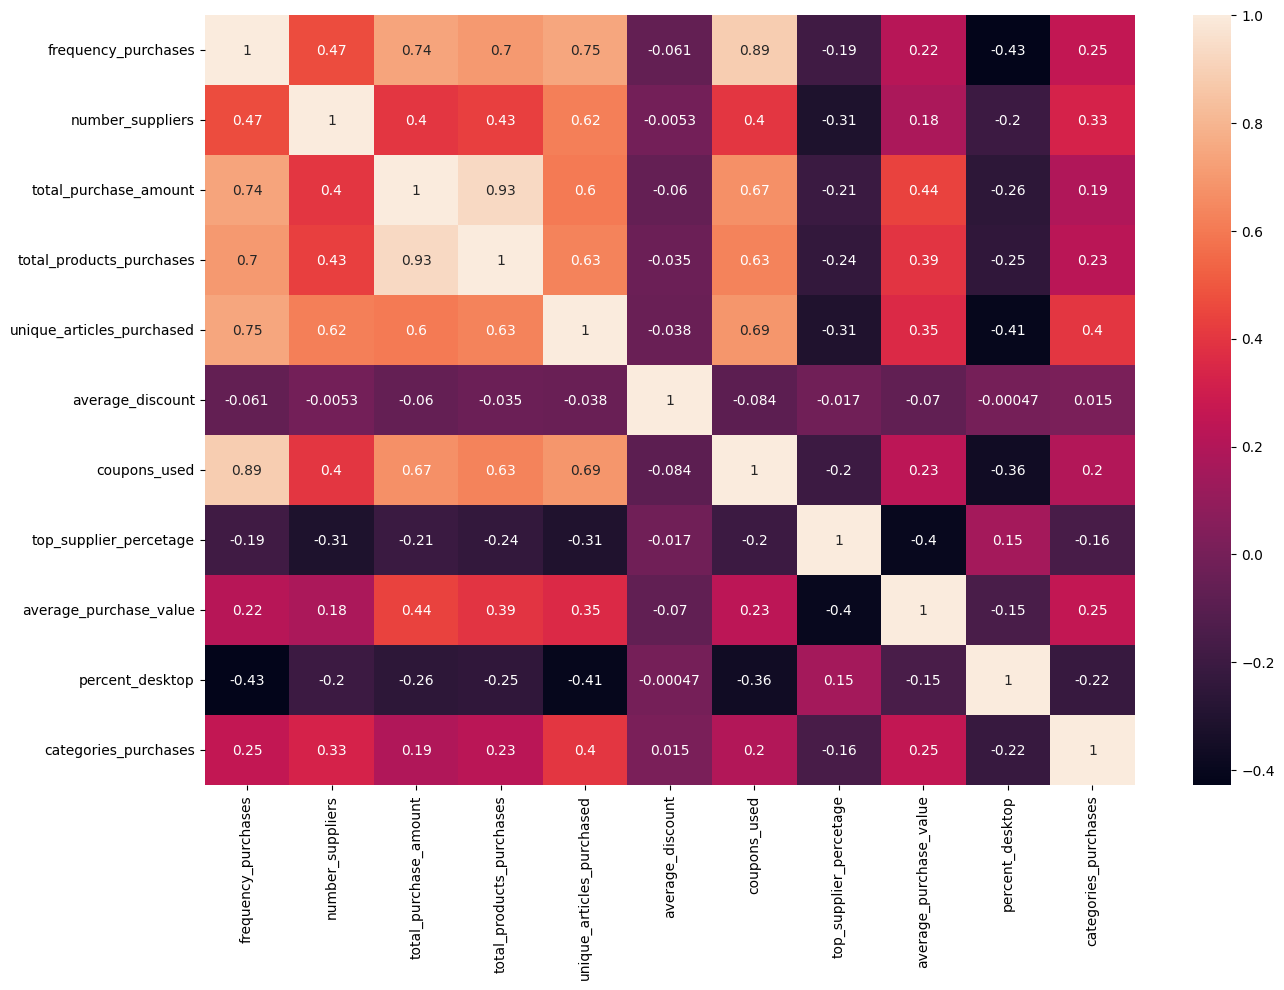

In [9]:
# Nur numerische 
num_cols = df.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix for numerical columns
corr_matrix = df[num_cols].corr()

# Display correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

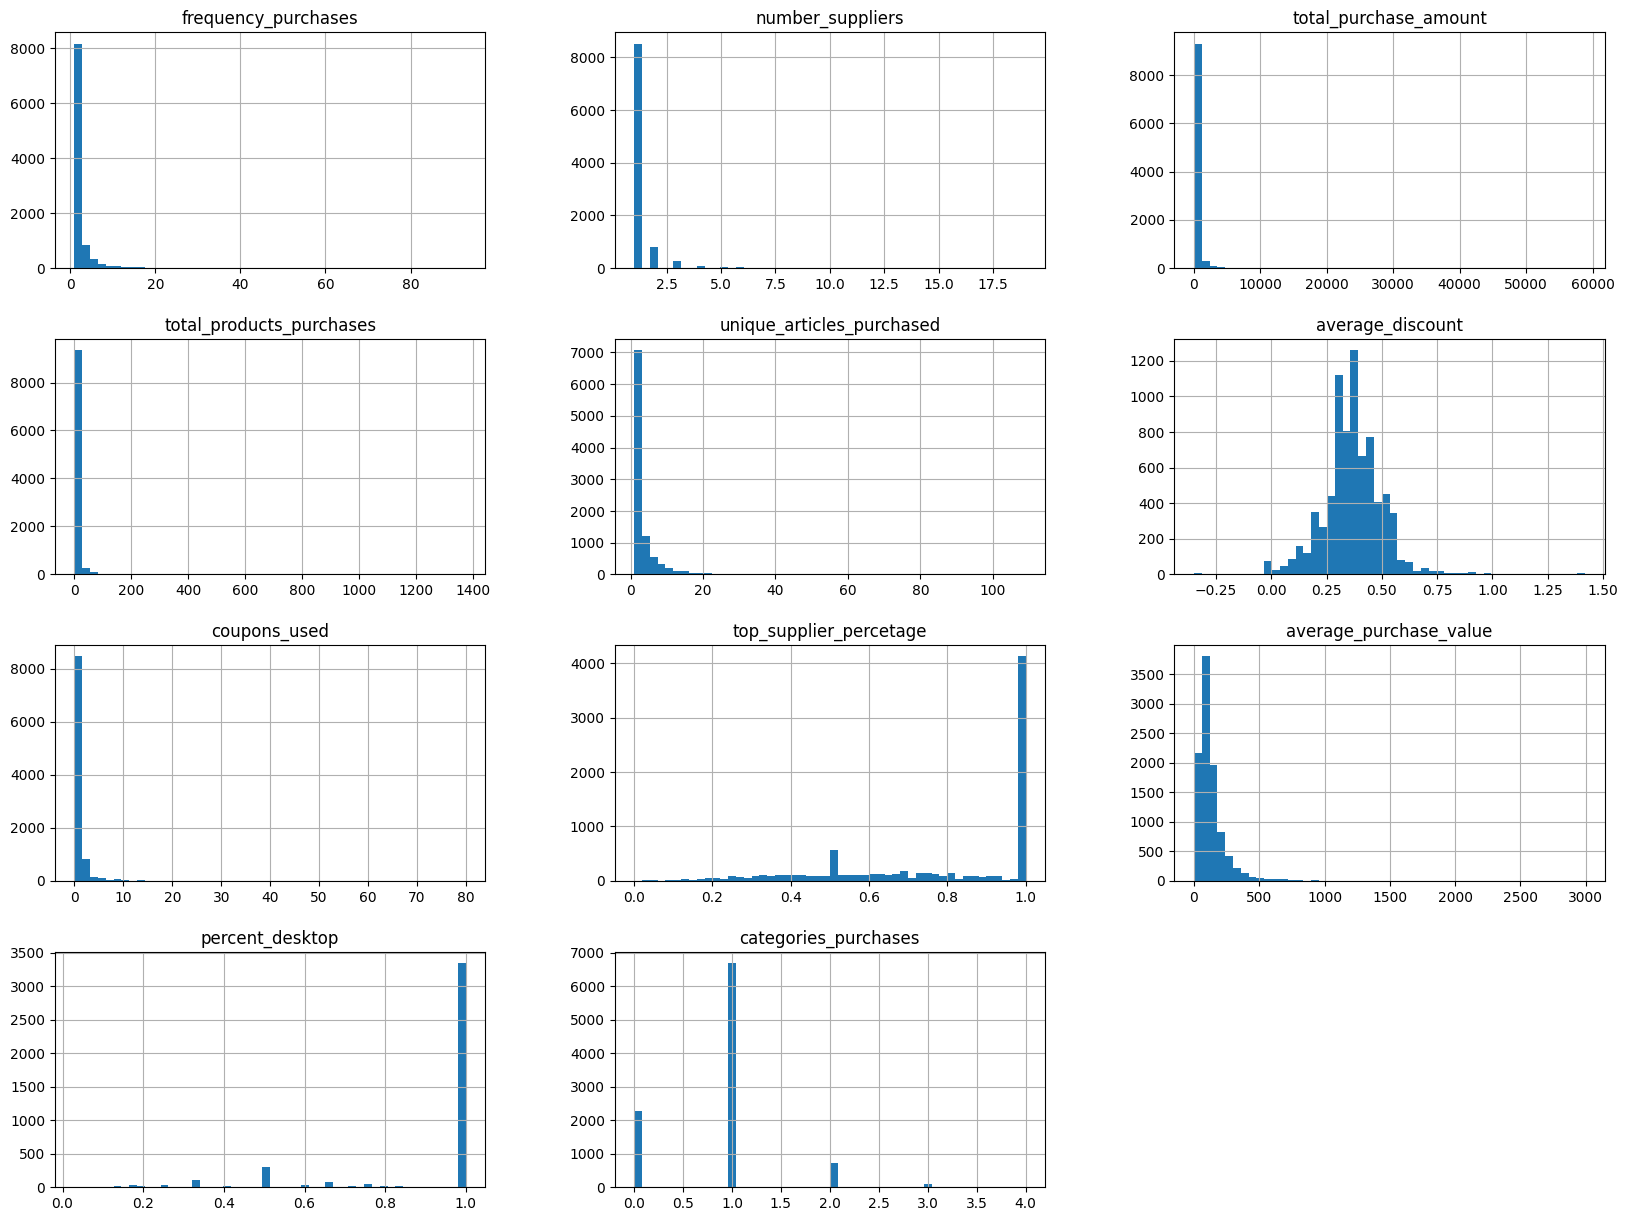

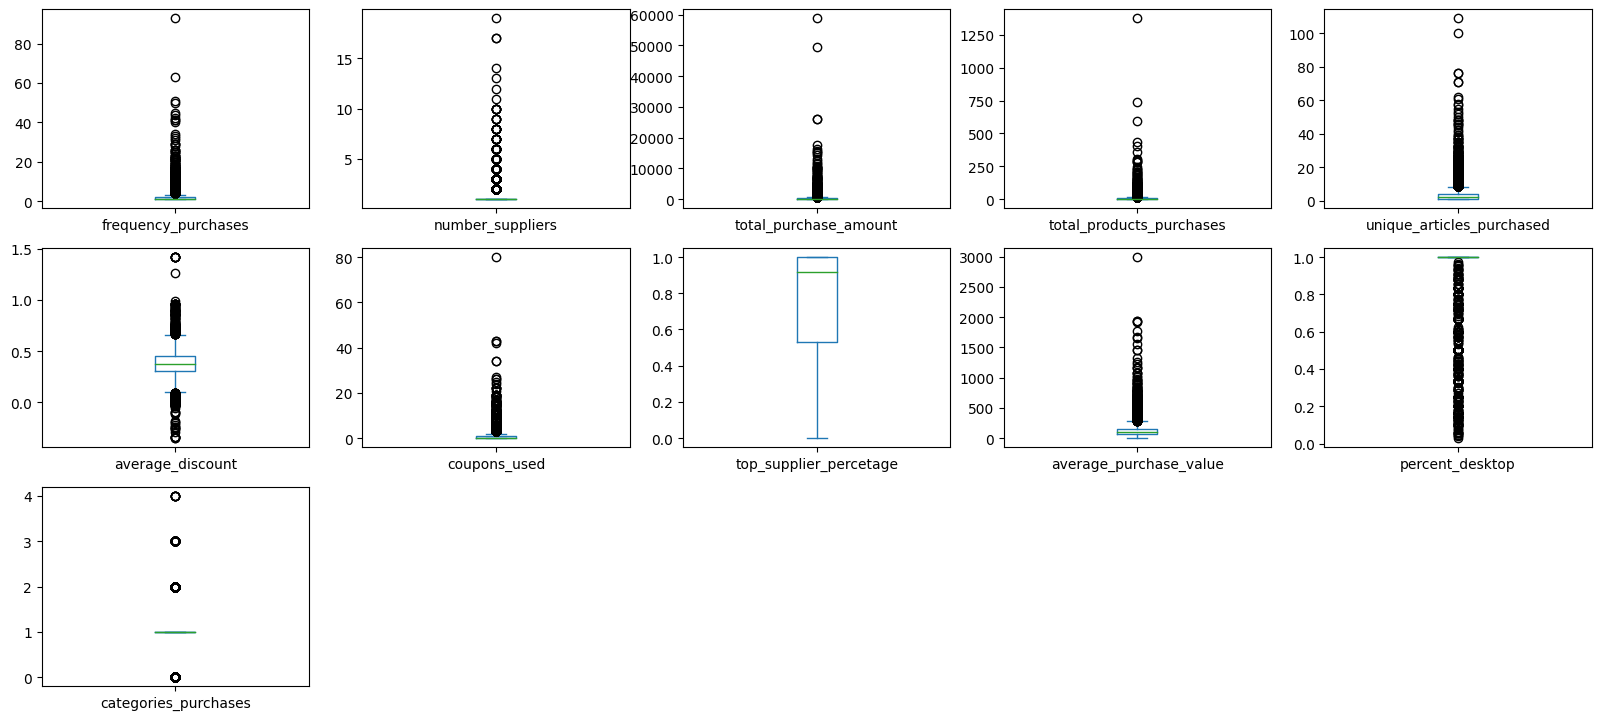

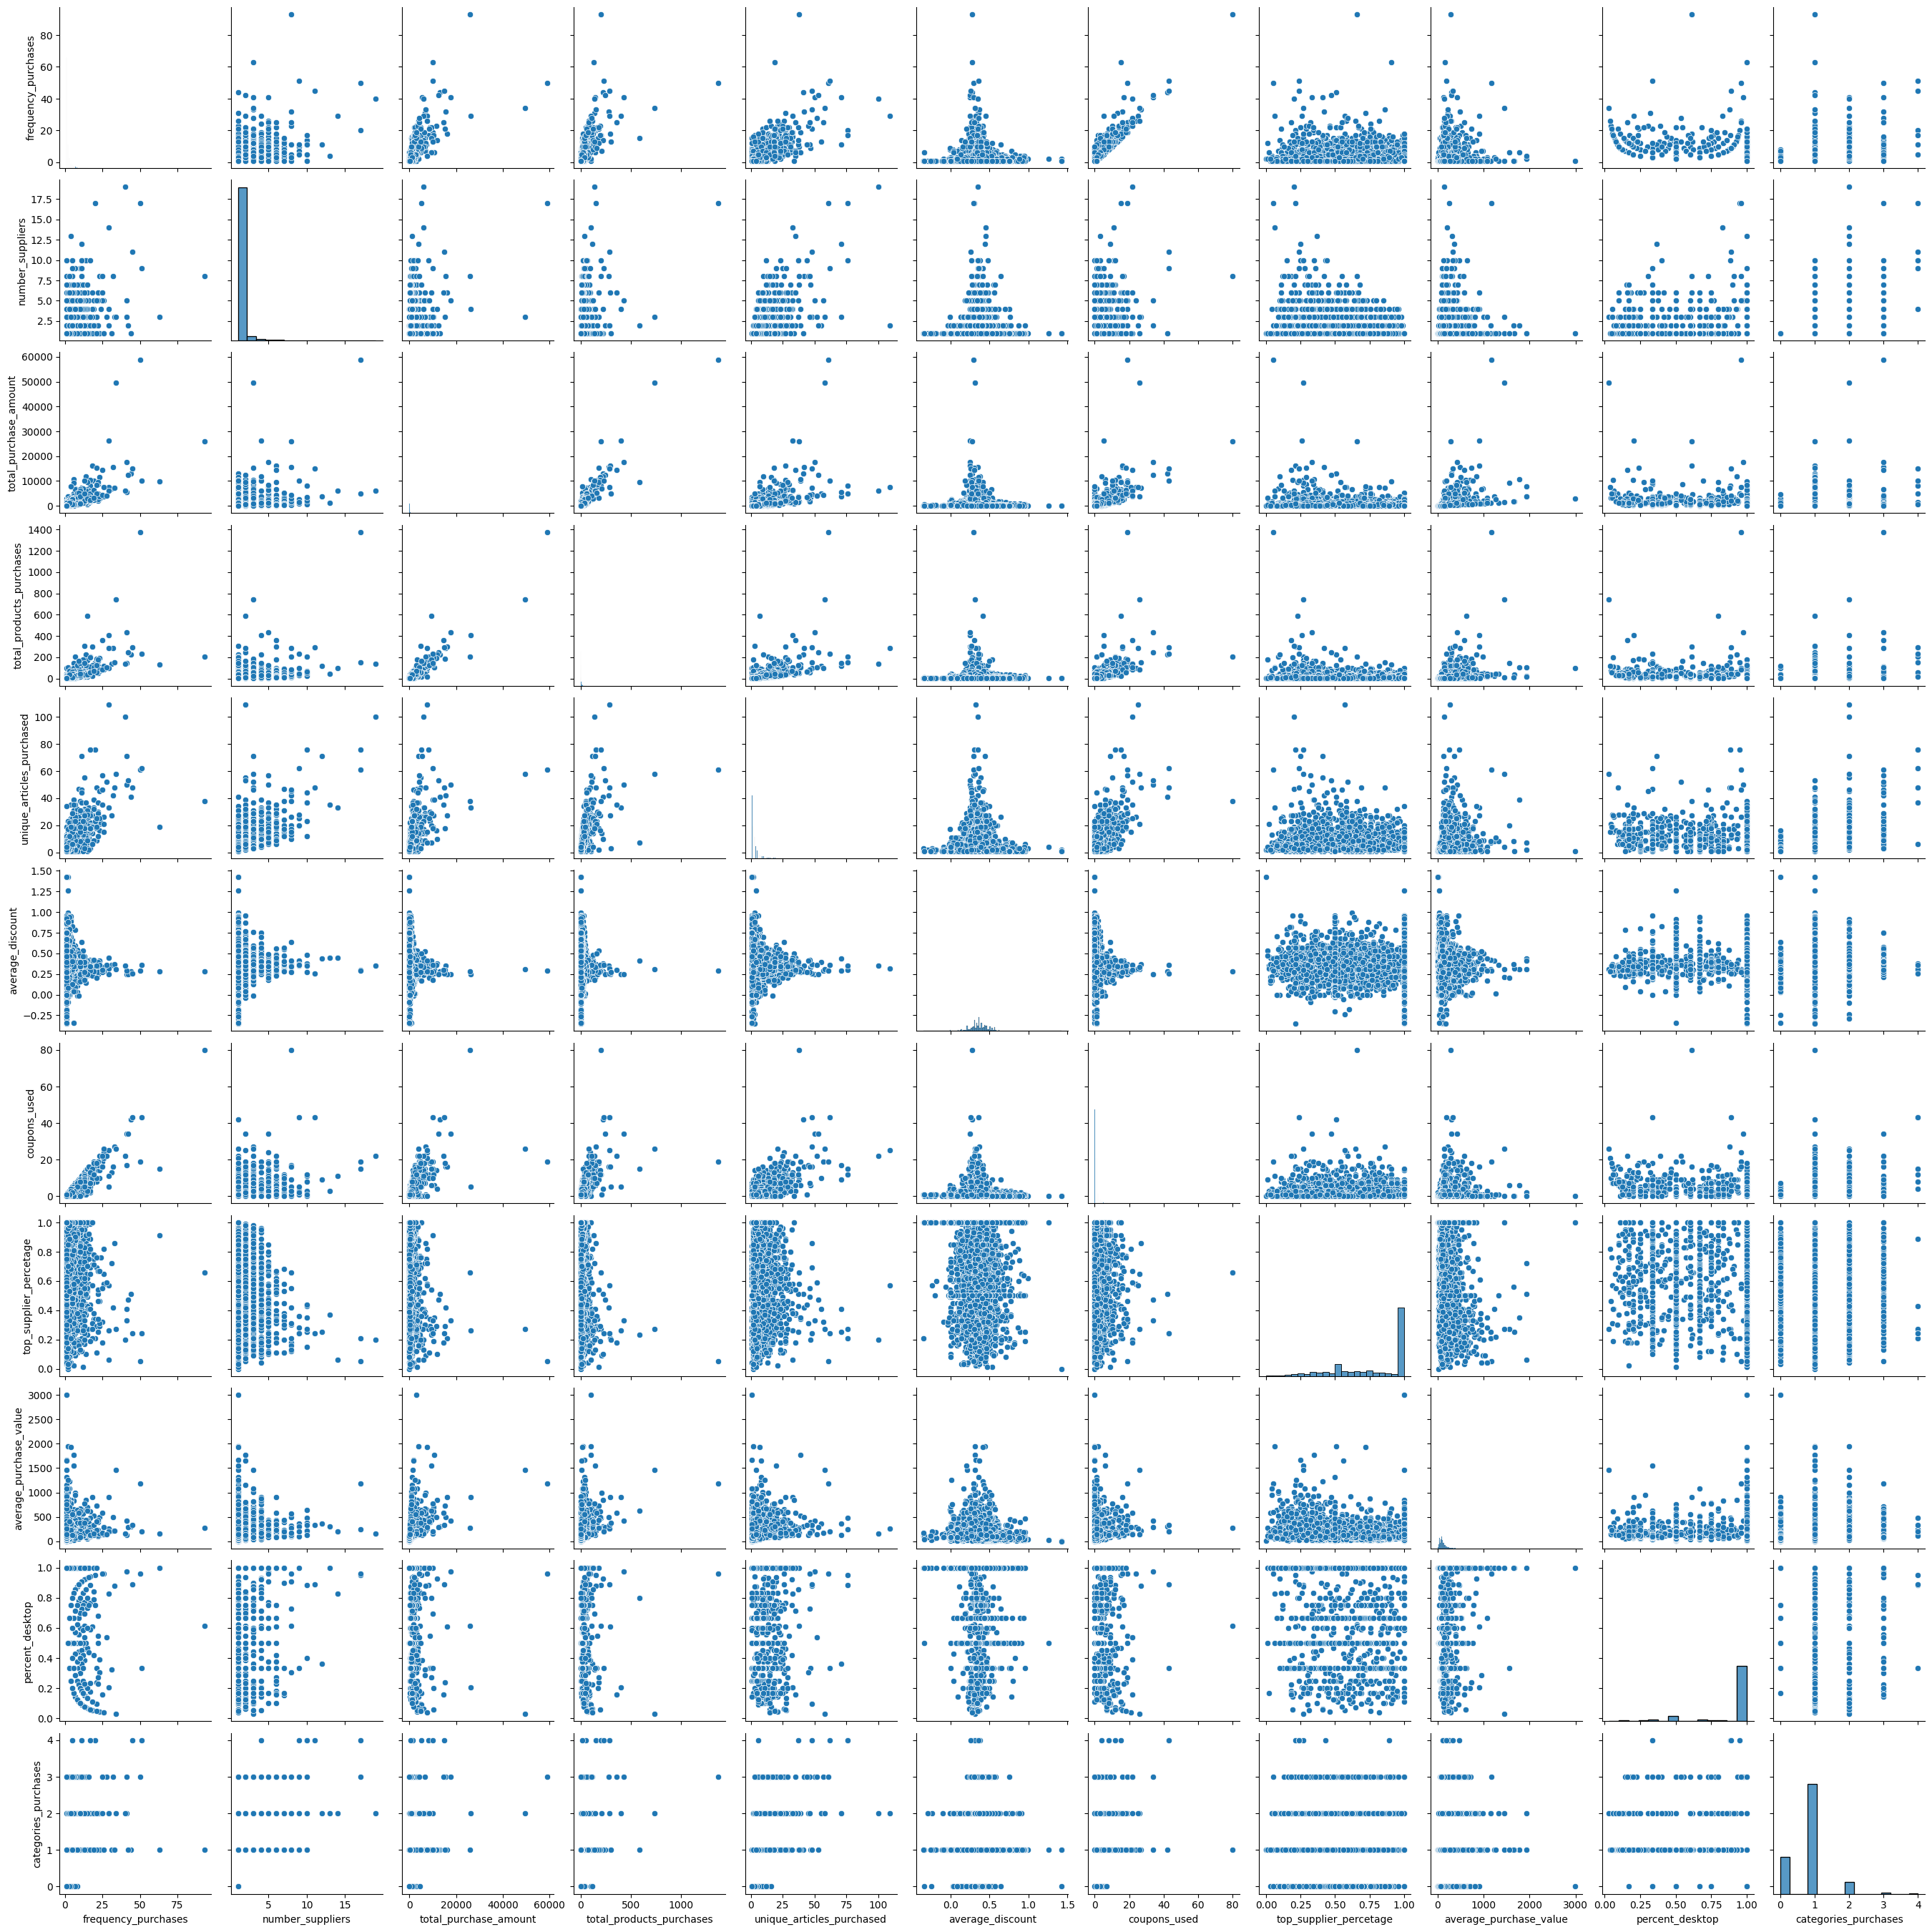

In [10]:
# Histograms für jedes Merkmal
df.hist(bins=50, figsize=(20,15))
plt.show()

# Box plots für jedes Merkmal
df.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,15))
plt.show()

# Scatter plot matrix
sns.pairplot(df)
plt.show()

### Ausreißern

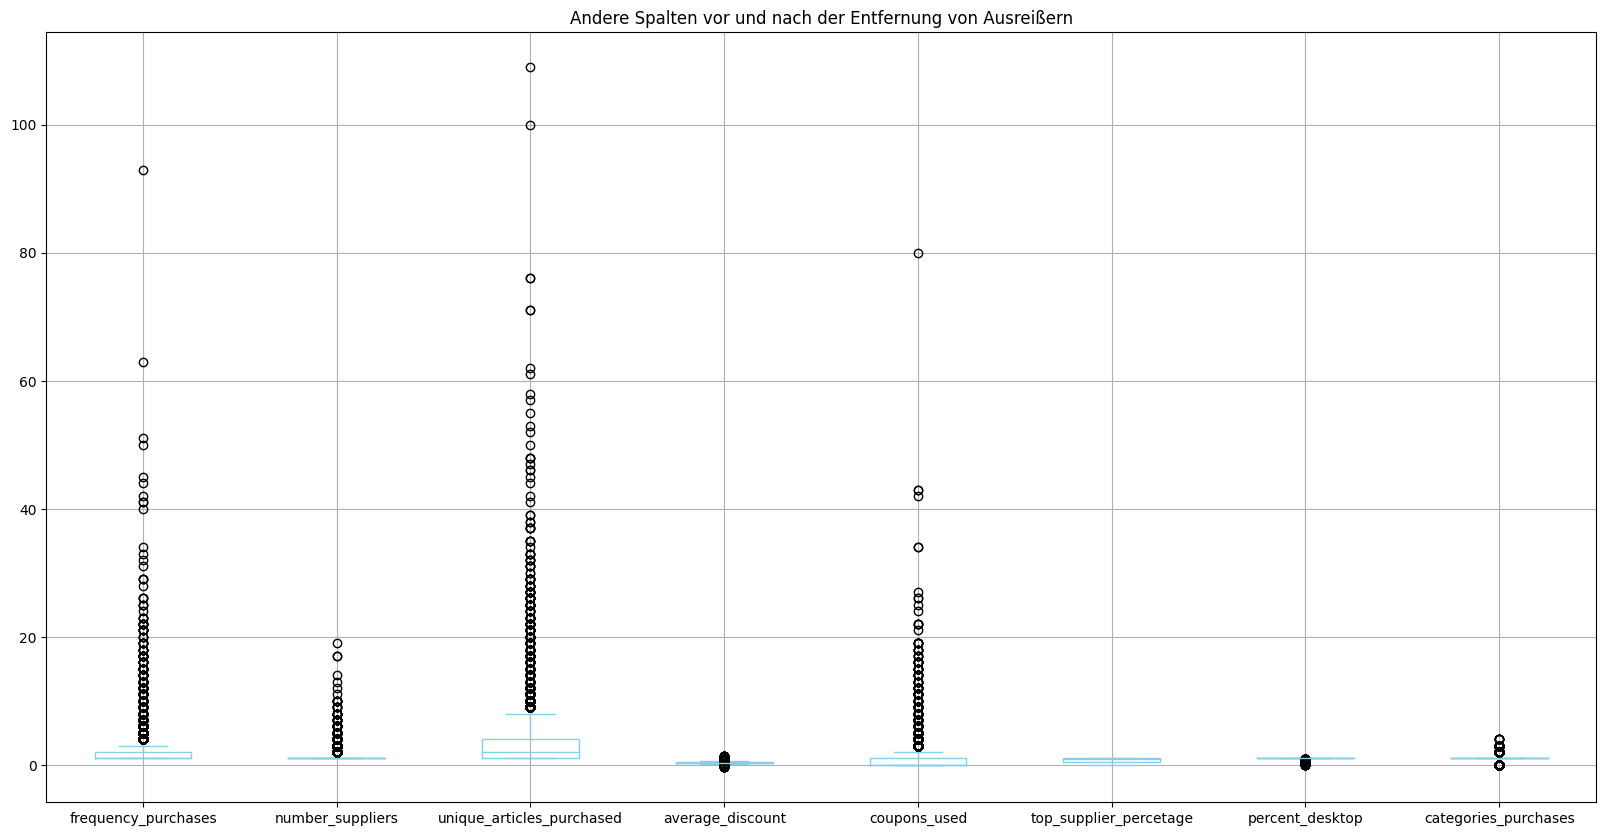

In [11]:
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Spalten mit großen Werten werden separat behandelt
specified_cols = ['total_purchase_amount', 'total_products_purchases', 'average_purchase_value']
other_cols = num_cols[~num_cols.isin(specified_cols)]

# Z-Scores für alle Spalten berechnen
z_scores_all = np.abs(stats.zscore(df[num_cols]))

# Ausreißer identifizieren mit einem Schwellenwert von 3
outliers_all = (z_scores_all > 3).any(axis=1)

# Dataframes für Ausreißer und Nicht-Ausreißer erstellen
outliers_df_all = df[outliers_all].copy()
non_outliers_df_all = df[~outliers_all].copy()

# Neue Spalte 'stage' hinzufügen, um den Status jeder Beobachtung zu identifizieren
outliers_df_all['stage'] = 'Ausreißer'
non_outliers_df_all['stage'] = 'Nicht-Ausreißer'

# Die Dataframes zusammenführen
combined_df_all = pd.concat([outliers_df_all, non_outliers_df_all], ignore_index=True)

# Subplots für jede Spalte erstellen
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Boxplots von 'total_purchase_amount', 'total_products_purchases', 'average_purchase_value'
sns.boxplot(x='stage', y='total_purchase_amount', data=combined_df_all, hue='stage', palette=['red', 'green'], ax=axes[0])
axes[0].set_title("Boxplot von 'total_purchase_amount'")

sns.boxplot(x='stage', y='total_products_purchases', data=combined_df_all, hue='stage', palette=['red', 'green'], ax=axes[1])
axes[1].set_title("Boxplot von 'total_products_purchases'")

sns.boxplot(x='stage', y='average_purchase_value', data=combined_df_all, hue='stage', palette=['red', 'green'], ax=axes[2])
axes[2].set_title("Boxplot von 'average_purchase_value'")

# Abstand zwischen den Subplots anpassen
plt.tight_layout()

# Die Plots anzeigen
plt.show()

# Boxplots der anderen Spalten vor und nach der Entfernung von Ausreißern
plt.figure(figsize=(20, 10))
combined_df_all[other_cols].boxplot(color='skyblue')
plt.title("Andere Spalten vor und nach der Entfernung von Ausreißern")
plt.show()


In [12]:
# Berechnen wie viele Einträge wurden entfernt 
rows_before = df.shape[0]
rows_after = df[~outliers_all].shape[0]
rows_removed = rows_before - rows_after
rows_percentage = rows_removed / rows_before * 100

print(f"Entfernt Ausreißern: {rows_removed}")
print(f"{rows_percentage} % sind entfernt")

Entfernt Ausreißern: 600
6.129955046996322 % sind entfernt


In [13]:
non_outliers_df = df[~outliers_all].copy()

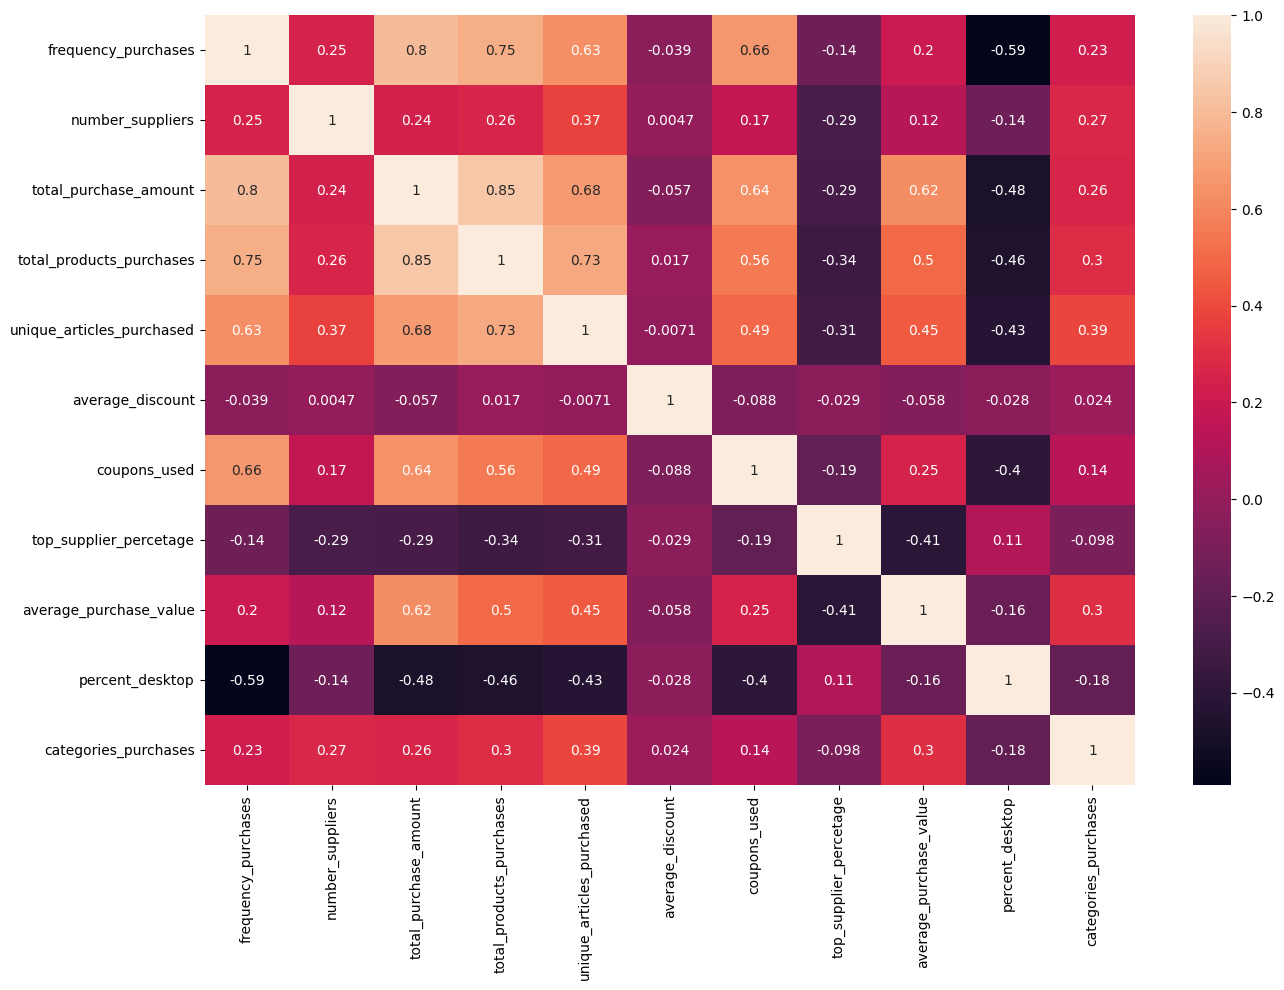

In [14]:
# Korellationsmatrix nach Ausreißern Entfernung
num_cols_no_outliers = non_outliers_df.select_dtypes(include=[np.number]).columns

corr_matrix_no_outliers = non_outliers_df[num_cols_no_outliers].corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix_no_outliers, annot=True)
plt.show()

In [15]:
# Noch mal alle Spalten visualisiert
non_outliers_df.hist(bins=50, figsize=(20,15))
plt.show()

non_outliers_df.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,15))
plt.show()

sns.pairplot(non_outliers_df)
plt.show()

## Fehlende Werte

In [16]:
# Durchschnitt und Median
cols_with_missing = ['average_discount', 'top_supplier_percetage', 'percent_desktop', 'Bundesland']

for col in cols_with_missing:
    if non_outliers_df[col].dtype != 'object':  # Exclude object dtype columns (e.g., Bundesland)
        mean = non_outliers_df[col].mean()
        median = non_outliers_df[col].median()
        print(f"{col}:\nMean: {mean}\nMedian: {median}\n")

average_discount:
Mean: 0.3694630590214496
Median: 0.37

top_supplier_percetage:
Mean: 0.7911913219994924
Median: 1.0

percent_desktop:
Mean: 0.9132849261849262
Median: 1.0



### Behandlung von fehlenden Werte

In [17]:
# Fehlende Werte mit Durchschnitt oder Median auffüllen
non_outliers_df['average_discount'].fillna(non_outliers_df['average_discount'].mean(), inplace=True)
non_outliers_df['top_supplier_percetage'].fillna(non_outliers_df['top_supplier_percetage'].median(), inplace=True)

# Fehlende Werte mit einem spezifischen Wert (Unknown) auffüllen
non_outliers_df['Bundesland'].fillna('Unknown', inplace=True)  # Fill with a specific value

# Löschen aufgrund einer großen Anzahl von fehlenden Werten
non_outliers_df.drop(columns=['percent_desktop'], inplace=True)

### One-hot encoding

In [18]:
#Spalte 'user_salutation'
salutation_dummies = pd.get_dummies(non_outliers_df['user_salutation'], prefix='salutation')
non_outliers_df = pd.concat([non_outliers_df, salutation_dummies], axis=1)
non_outliers_df.drop(columns=['user_salutation'], inplace=True)

#Spalte 'Bundesland'
bundesland_dummies = pd.get_dummies(non_outliers_df['Bundesland'], prefix='bundesland')
non_outliers_df = pd.concat([non_outliers_df, bundesland_dummies], axis=1)
non_outliers_df.drop(columns=['Bundesland'], inplace=True)
#deleting bc its not important for clustering
non_outliers_df.drop(columns=['user_email'], inplace=True)

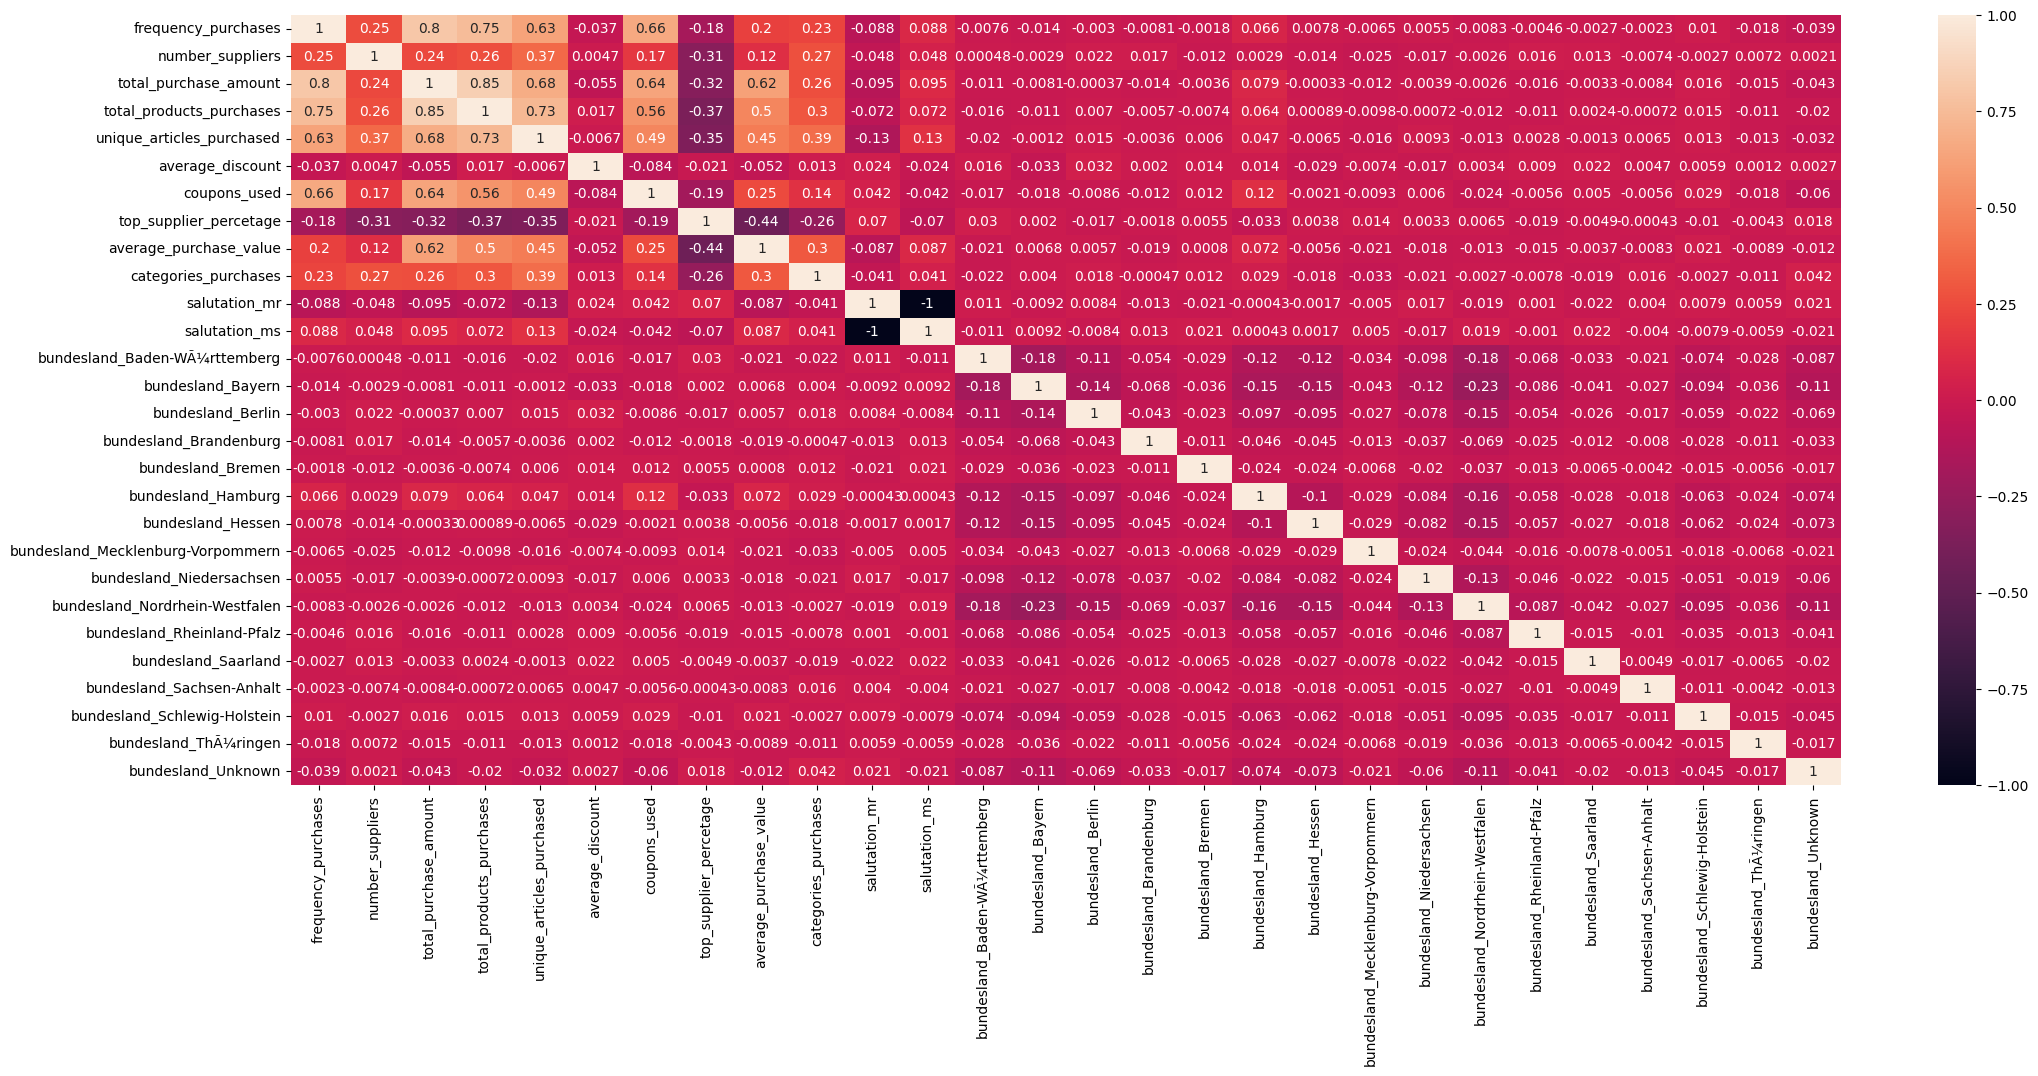

In [19]:
# Neue Korrelationsmatrize
corr_matrix = non_outliers_df.corr()

# plot
plt.figure(figsize=(25,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [20]:
# Neue Spalten
non_outliers_df.columns

Index(['frequency_purchases', 'number_suppliers', 'total_purchase_amount',
       'total_products_purchases', 'unique_articles_purchased',
       'average_discount', 'coupons_used', 'top_supplier_percetage',
       'average_purchase_value', 'categories_purchases', 'salutation_mr',
       'salutation_ms', 'bundesland_Baden-WÃ¼rttemberg', 'bundesland_Bayern',
       'bundesland_Berlin', 'bundesland_Brandenburg', 'bundesland_Bremen',
       'bundesland_Hamburg', 'bundesland_Hessen',
       'bundesland_Mecklenburg-Vorpommern', 'bundesland_Niedersachsen',
       'bundesland_Nordrhein-Westfalen', 'bundesland_Rheinland-Pfalz',
       'bundesland_Saarland', 'bundesland_Sachsen-Anhalt',
       'bundesland_Schlewig-Holstein', 'bundesland_ThÃ¼ringen',
       'bundesland_Unknown'],
      dtype='object')

In [21]:
#Anzeige von neuer Tabelle
non_outliers_df.head()

frequency_purchases  number_suppliers  total_purchase_amount   
0                   10                 1                1264.61  \
1                    1                 1                  37.20   
2                    1                 2                 132.66   
3                    1                 1                  95.78   
4                    1                 1                  81.51   

   total_products_purchases  unique_articles_purchased  average_discount   
0                        25                         12              0.16  \
1                         2                          1              0.76   
2                         2                          2              0.54   
3                         2                          2              0.51   
4                         3                          1              0.45   

   coupons_used  top_supplier_percetage  average_purchase_value   
0             7                    0.41                 126.461  \
1             0                    1.00                  37.200   
2             0                    0.85                 132.660   
3             0                    1.00                  95.780   
4             0                    1.00                  81.510   

   categories_purchases  ...  bundesland_Hessen   
0                     1  ...              False  \
1                     1  ...              False   
2                     1  ...              False   
3                     1  ...              False   
4                     1  ...              False   

   bundesland_Mecklenburg-Vorpommern  bundesland_Niedersachsen   
0                              False                     False  \
1                              False                      True   
2                              False                     False   
3                              False                     False   
4                              False                     False   

   bundesland_Nordrhein-Westfalen  bundesland_Rheinland-Pfalz   
0                           False                        True  \
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   bundesland_Saarland  bundesland_Sachsen-Anhalt   
0                False                      False  \
1                False                      False   
2                False                      False   
3                False                      False   
4                False                      False   

   bundesland_Schlewig-Holstein  bundesland_ThÃ¼ringen  bundesland_Unknown  
0                         False                  False               False  
1                         False                  False               False  
2                         False                  False               False  
3                         False                  False               False  
4                         False                  False               False  

[5 rows x 28 columns]

In [22]:
#Beschreibung der neuen Tabelle
non_outliers_df.describe()

frequency_purchases  number_suppliers  total_purchase_amount   
count          9188.000000       9188.000000            9188.000000  \
mean              1.568894          1.119613             203.638289   
std               1.247503          0.384406             266.778017   
min               1.000000          1.000000               0.000000   
25%               1.000000          1.000000              69.417500   
50%               1.000000          1.000000             112.245000   
75%               2.000000          1.000000             225.605000   
max              10.000000          3.000000            3081.540000   

       total_products_purchases  unique_articles_purchased  average_discount   
count               9188.000000                9188.000000       9188.000000  \
mean                   4.904985                   2.743796          0.369463   
std                    6.050422                   2.506569          0.122212   
min                    1.000000                   1.000000         -0.350000   
25%                    2.000000                   1.000000          0.310000   
50%                    3.000000                   2.000000          0.369463   
75%                    6.000000                   3.000000          0.420000   
max                   72.000000                  18.000000          1.420000   

       coupons_used  top_supplier_percetage  average_purchase_value   
count   9188.000000             9188.000000             9188.000000  \
mean       0.577166                0.820872              116.979830   
std        0.950746                0.249024               79.342713   
min        0.000000                0.000000                0.000000   
25%        0.000000                0.620000               64.113750   
50%        0.000000                1.000000               97.355000   
75%        1.000000                1.000000              146.368750   
max        7.000000                1.000000              496.800000   

       categories_purchases  
count           9188.000000  
mean               0.819438  
std                0.526995  
min                0.000000  
25%                1.000000  
50%                1.000000  
75%                1.000000  
max                2.000000

## Skalierung der Daten

### Finding numerical columns and defining copies of data for different scalers
(aus der Erfahrung, klappt es nicht so gut mit Standard Scaler)

In [23]:
# Numerische Spalten
numerical_columns = non_outliers_df.select_dtypes(include=np.number).columns
# Verschiedene Typen von Skalierungen
standard_scaled_df = non_outliers_df.copy()
robust_scaled_df = non_outliers_df.copy()
power_transformer_scaled_df = non_outliers_df.copy()

In [24]:
numerical_columns

Index(['frequency_purchases', 'number_suppliers', 'total_purchase_amount',
       'total_products_purchases', 'unique_articles_purchased',
       'average_discount', 'coupons_used', 'top_supplier_percetage',
       'average_purchase_value', 'categories_purchases'],
      dtype='object')

In [25]:
non_outliers_df.columns

Index(['frequency_purchases', 'number_suppliers', 'total_purchase_amount',
       'total_products_purchases', 'unique_articles_purchased',
       'average_discount', 'coupons_used', 'top_supplier_percetage',
       'average_purchase_value', 'categories_purchases', 'salutation_mr',
       'salutation_ms', 'bundesland_Baden-WÃ¼rttemberg', 'bundesland_Bayern',
       'bundesland_Berlin', 'bundesland_Brandenburg', 'bundesland_Bremen',
       'bundesland_Hamburg', 'bundesland_Hessen',
       'bundesland_Mecklenburg-Vorpommern', 'bundesland_Niedersachsen',
       'bundesland_Nordrhein-Westfalen', 'bundesland_Rheinland-Pfalz',
       'bundesland_Saarland', 'bundesland_Sachsen-Anhalt',
       'bundesland_Schlewig-Holstein', 'bundesland_ThÃ¼ringen',
       'bundesland_Unknown'],
      dtype='object')

### StandardScaler

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standard_scaled_df[numerical_columns] = scaler.fit_transform(non_outliers_df[numerical_columns])
standard_scaled_df.head()

frequency_purchases  number_suppliers  total_purchase_amount   
0             6.758754         -0.311179               3.977200  \
1            -0.456051         -0.311179              -0.623917   
2            -0.456051          2.290378              -0.266072   
3            -0.456051         -0.311179              -0.404322   
4            -0.456051         -0.311179              -0.457815   

   total_products_purchases  unique_articles_purchased  average_discount   
0                  3.321439                   3.692979         -1.714020  \
1                 -0.480155                  -0.695728          3.195733   
2                 -0.480155                  -0.296755          1.395490   
3                 -0.480155                  -0.296755          1.150003   
4                 -0.314869                  -0.695728          0.659027   

   coupons_used  top_supplier_percetage  average_purchase_value   
0      6.755943               -1.650016                0.119503  \
1     -0.607100                0.719359               -1.005564   
2     -0.607100                0.116976                0.197637   
3     -0.607100                0.719359               -0.267208   
4     -0.607100                0.719359               -0.447070   

   categories_purchases  ...  bundesland_Hessen   
0              0.342644  ...              False  \
1              0.342644  ...              False   
2              0.342644  ...              False   
3              0.342644  ...              False   
4              0.342644  ...              False   

   bundesland_Mecklenburg-Vorpommern  bundesland_Niedersachsen   
0                              False                     False  \
1                              False                      True   
2                              False                     False   
3                              False                     False   
4                              False                     False   

   bundesland_Nordrhein-Westfalen  bundesland_Rheinland-Pfalz   
0                           False                        True  \
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   bundesland_Saarland  bundesland_Sachsen-Anhalt   
0                False                      False  \
1                False                      False   
2                False                      False   
3                False                      False   
4                False                      False   

   bundesland_Schlewig-Holstein  bundesland_ThÃ¼ringen  bundesland_Unknown  
0                         False                  False               False  
1                         False                  False               False  
2                         False                  False               False  
3                         False                  False               False  
4                         False                  False               False  

[5 rows x 28 columns]

### RobustScaler

In [27]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
robust_scaled_df[numerical_columns] = scaler.fit_transform(non_outliers_df[numerical_columns])
robust_scaled_df.head()

frequency_purchases  number_suppliers  total_purchase_amount   
0                  9.0               0.0               7.378087  \
1                  0.0               0.0              -0.480480   
2                  0.0               1.0               0.130708   
3                  0.0               0.0              -0.105418   
4                  0.0               0.0              -0.196783   

   total_products_purchases  unique_articles_purchased  average_discount   
0                      5.50                        5.0         -1.904210  \
1                     -0.25                       -0.5          3.550336   
2                     -0.25                        0.0          1.550336   
3                     -0.25                        0.0          1.277609   
4                      0.00                       -0.5          0.732154   

   coupons_used  top_supplier_percetage  average_purchase_value   
0           7.0               -1.552632                0.353851  \
1           0.0                0.000000               -0.731323   
2           0.0               -0.394737                0.429214   
3           0.0                0.000000               -0.019148   
4           0.0                0.000000               -0.192633   

   categories_purchases  ...  bundesland_Hessen   
0                   0.0  ...              False  \
1                   0.0  ...              False   
2                   0.0  ...              False   
3                   0.0  ...              False   
4                   0.0  ...              False   

   bundesland_Mecklenburg-Vorpommern  bundesland_Niedersachsen   
0                              False                     False  \
1                              False                      True   
2                              False                     False   
3                              False                     False   
4                              False                     False   

   bundesland_Nordrhein-Westfalen  bundesland_Rheinland-Pfalz   
0                           False                        True  \
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   bundesland_Saarland  bundesland_Sachsen-Anhalt   
0                False                      False  \
1                False                      False   
2                False                      False   
3                False                      False   
4                False                      False   

   bundesland_Schlewig-Holstein  bundesland_ThÃ¼ringen  bundesland_Unknown  
0                         False                  False               False  
1                         False                  False               False  
2                         False                  False               False  
3                         False                  False               False  
4                         False                  False               False  

[5 rows x 28 columns]

### Power Transformer

In [28]:
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method='yeo-johnson')
power_transformer_scaled_df[numerical_columns] = transformer.fit_transform(non_outliers_df[numerical_columns])
power_transformer_scaled_df.head()

frequency_purchases  number_suppliers  total_purchase_amount   
0             1.864532         -0.330342               2.284079  \
1            -0.615267         -0.330342              -1.302196   
2            -0.615267          3.027055               0.098121   
3            -0.615267         -0.330342              -0.249493   
4            -0.615267         -0.330342              -0.424599   

   total_products_purchases  unique_articles_purchased  average_discount   
0                  1.934464                   1.891029         -1.739093  \
1                 -0.474553                  -1.064330          3.104068   
2                 -0.474553                   0.105147          1.386315   
3                 -0.474553                   0.105147          1.147378   
4                  0.044727                  -1.064330          0.665830   

   coupons_used  top_supplier_percetage  average_purchase_value   
0      1.828662               -1.545294                0.383352  \
1     -0.794520                0.790225               -1.326593   
2     -0.794520               -0.241700                0.458630   
3     -0.794520                0.790225               -0.040708   
4     -0.794520                0.790225               -0.276925   

   categories_purchases  ...  bundesland_Hessen   
0              0.325543  ...              False  \
1              0.325543  ...              False   
2              0.325543  ...              False   
3              0.325543  ...              False   
4              0.325543  ...              False   

   bundesland_Mecklenburg-Vorpommern  bundesland_Niedersachsen   
0                              False                     False  \
1                              False                      True   
2                              False                     False   
3                              False                     False   
4                              False                     False   

   bundesland_Nordrhein-Westfalen  bundesland_Rheinland-Pfalz   
0                           False                        True  \
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   bundesland_Saarland  bundesland_Sachsen-Anhalt   
0                False                      False  \
1                False                      False   
2                False                      False   
3                False                      False   
4                False                      False   

   bundesland_Schlewig-Holstein  bundesland_ThÃ¼ringen  bundesland_Unknown  
0                         False                  False               False  
1                         False                  False               False  
2                         False                  False               False  
3                         False                  False               False  
4                         False                  False               False  

[5 rows x 28 columns]

## Visualiesierung, Suche nach optimalen Anzahl der Clusters

### PCA 

In [29]:
import numpy as np

from sklearn.decomposition import PCA

def plot_pca(data, title):
    # PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(data)

    # subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # scatter plot
    axes[0].scatter(pca_components[:, 0], pca_components[:, 1])
    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")
    axes[0].set_title(title)

    # bar plot of explained variance ratio
    axes[1].bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    axes[1].set_ylabel('Explained Variance Ratio')
    axes[1].set_xlabel('Principal Components')
    axes[1].set_title('Explained Variance Ratio per Principal Component')

    # Positionierung, Abstand zwischen
    plt.subplots_adjust(wspace=0.4)

    # Plot
    plt.show()


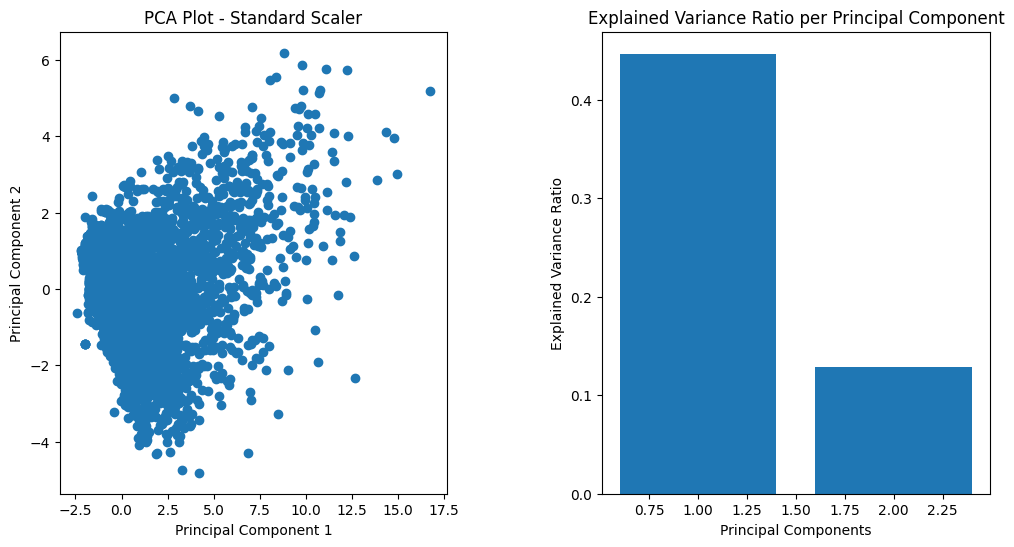

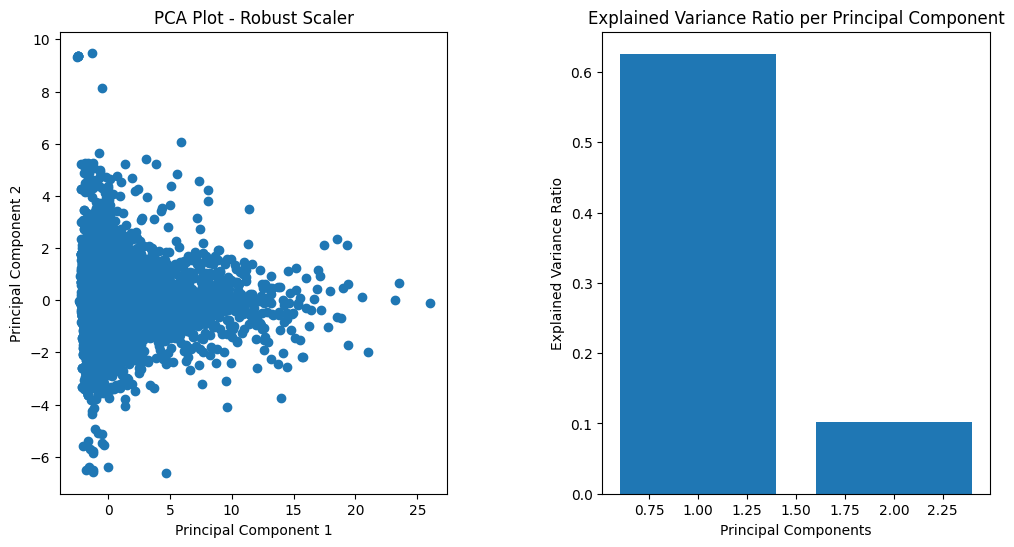

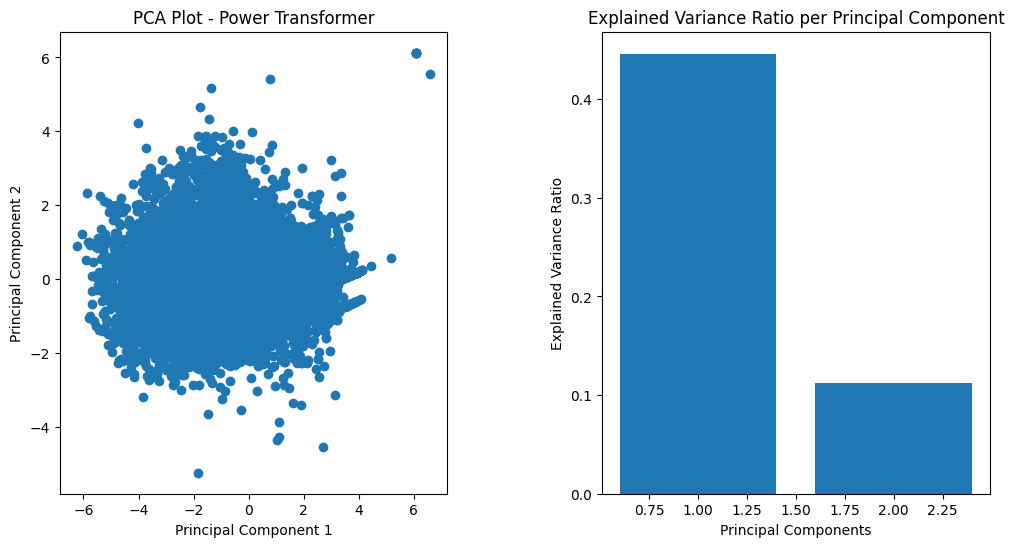

In [30]:
# Plot PCA für standard Scaler
plot_pca(standard_scaled_df[numerical_columns], "PCA Plot - Standard Scaler")

#Plot PCA für Robust Scaler
plot_pca(robust_scaled_df[numerical_columns], "PCA Plot - Robust Scaler")

#Plot PCA für Power Transformer
plot_pca(power_transformer_scaled_df[numerical_columns], "PCA Plot - Power Transformer")

### Elbow Curve mit KMeans

In [31]:
from sklearn.cluster import KMeans
def plot_elbow(data, title):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Optimale Anzahl der Cluster finden
    diff = np.diff(wcss)
    diff_r = diff[1:] / diff[:-1]
    optimal_clusters = np.argmin(diff_r) + 2  # Add 2 since the range starts from 1

    # Elbow curve
    plt.plot(range(1, 11), wcss)
    plt.scatter(optimal_clusters, wcss[optimal_clusters-1], color='red', marker='o', label='Optimal')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.legend()
    plt.show()

### Versuch mit allen Spalten, auch mit Onehot encoded

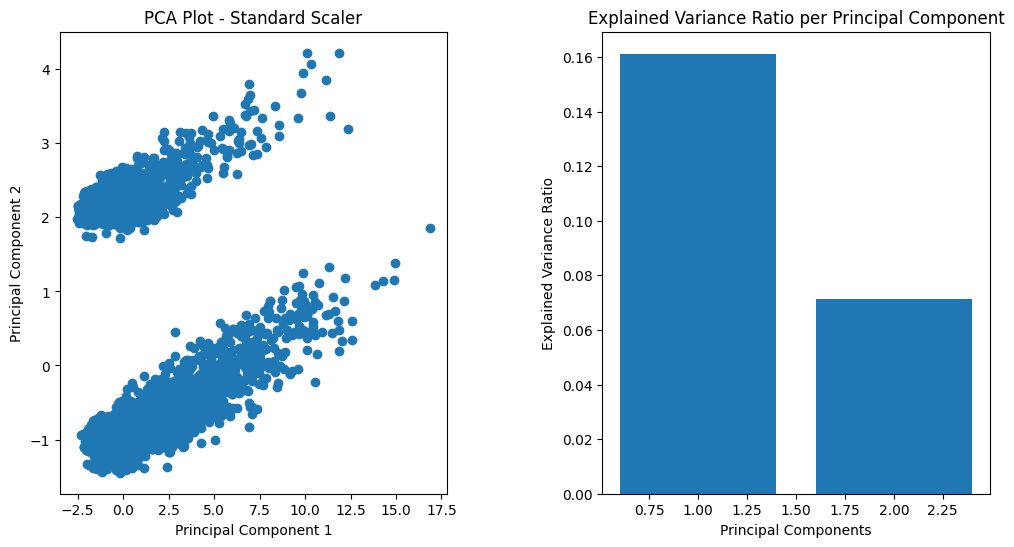

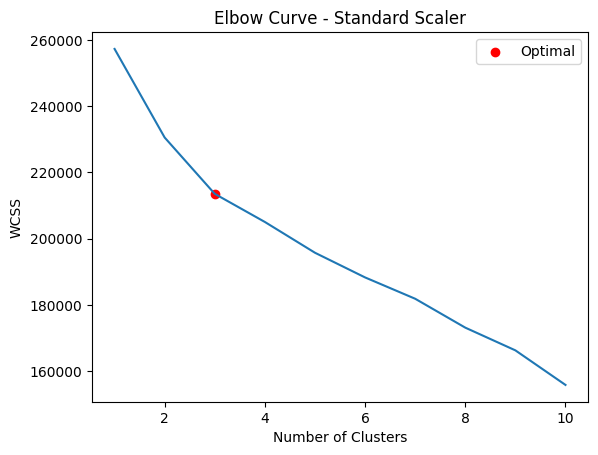

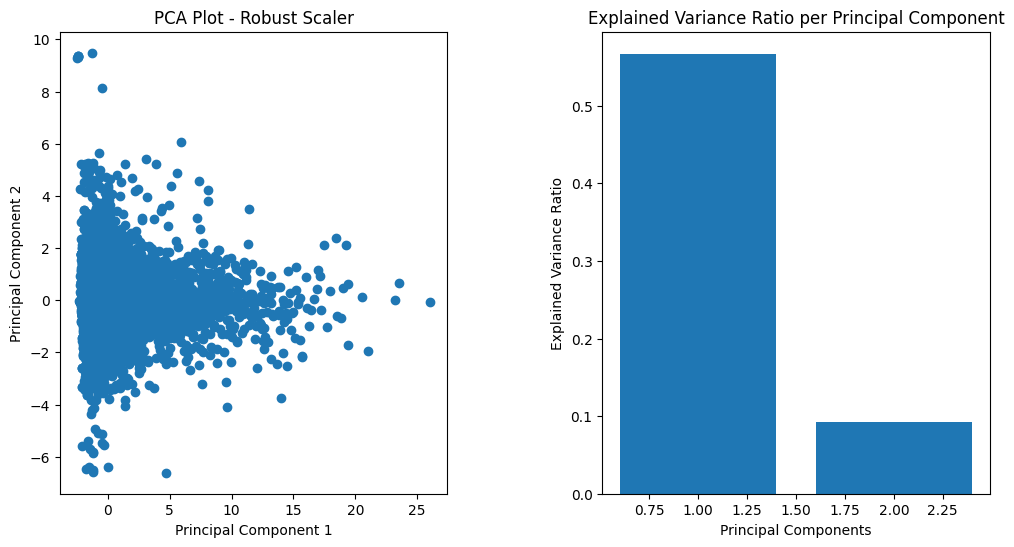

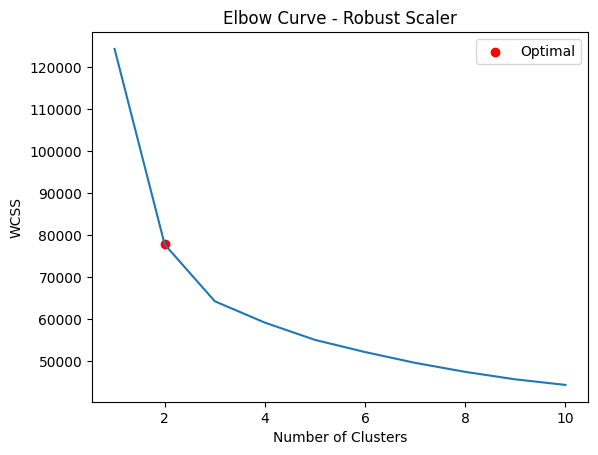

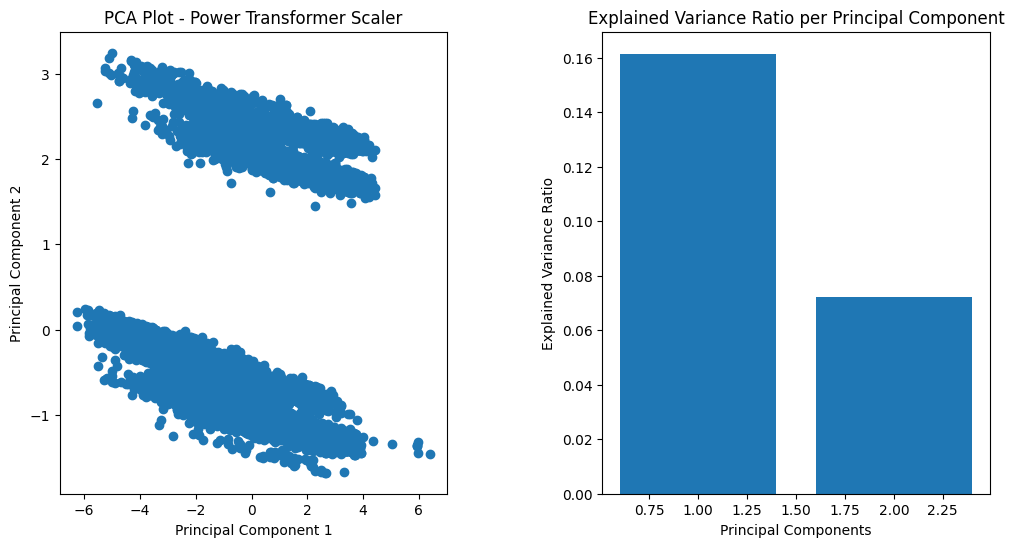

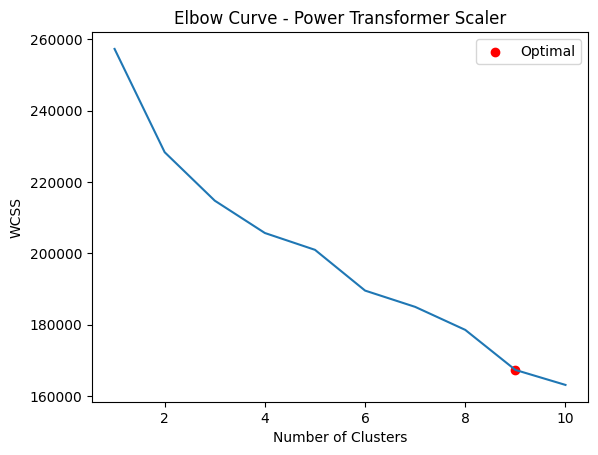

In [47]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

# Define all columns
all_columns = non_outliers_df.columns.tolist()

# Initialize scalers and dataframes
scalers = [StandardScaler(), RobustScaler(), PowerTransformer(method='yeo-johnson')]
scaled_dfs = [standard_scaled_df, robust_scaled_df, power_transformer_scaled_df]
scaler_names = ["Standard Scaler", "Robust Scaler", "Power Transformer Scaler"]

# Scale data and plot PCA and Elbow Curve for each scaler
for scaler, scaled_df, scaler_name in zip(scalers, scaled_dfs, scaler_names):
    scaled_df[all_columns] = scaler.fit_transform(non_outliers_df[all_columns])
    
    # Plot PCA
    plot_pca(scaled_df[all_columns], f"PCA Plot - {scaler_name}")
    
    # Plot Elbow Curve
    plot_elbow(scaled_df[all_columns], f"Elbow Curve - {scaler_name}")

### Elbow Curve für 3 Scaled Datensätze + PCA für alle 3 

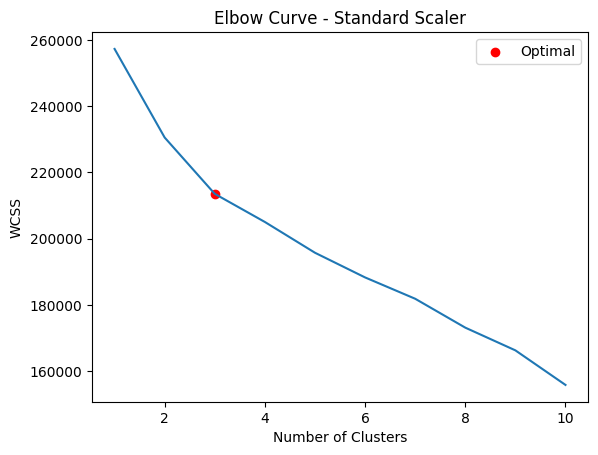

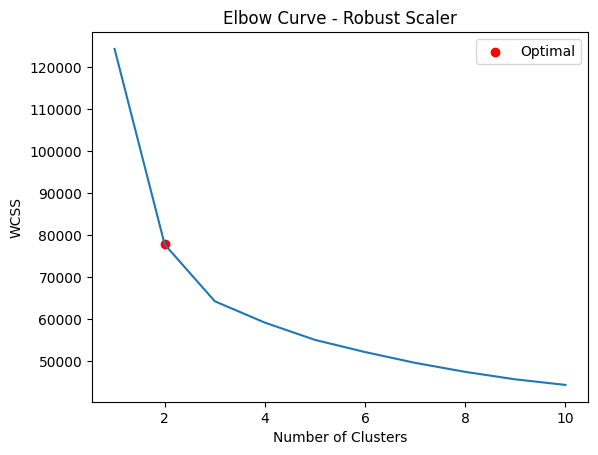

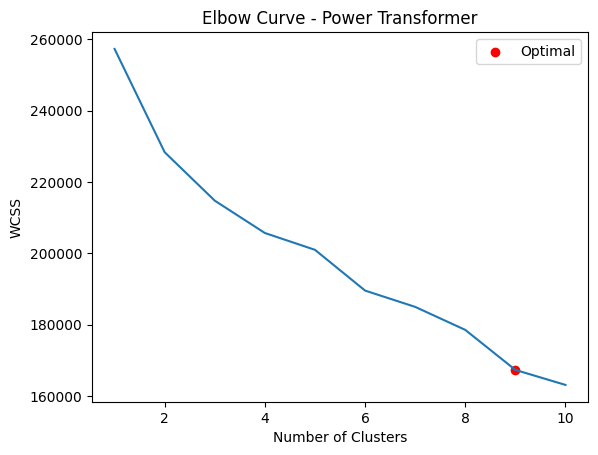

In [46]:
from sklearn.decomposition import PCA

# Elbow curve
plot_elbow(standard_scaled_df, "Elbow Curve - Standard Scaler")
plot_elbow(robust_scaled_df, "Elbow Curve - Robust Scaler")
plot_elbow(power_transformer_scaled_df, "Elbow Curve - Power Transformer")

# Neue Variablen nach PCA 
pca = PCA()
standard_scaled_pca = pca.fit_transform(standard_scaled_df)
robust_scaled_pca = pca.fit_transform(robust_scaled_df)
power_transformer_scaled_pca = pca.fit_transform(power_transformer_scaled_df)

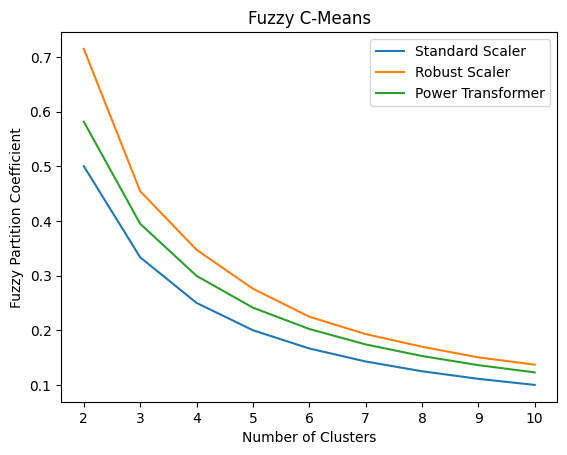

In [34]:
from skfuzzy.cluster import cmeans


# Skalierte Datensätze
scaled_datasets = {
    'Standard Scaler': standard_scaled_pca,
    'Robust Scaler': robust_scaled_pca,
    'Power Transformer': power_transformer_scaled_pca
}

# Plot Fuzzy Partition Coefficient (FPC) for jede Anzahl der Clusters
for scaler_name, data in scaled_datasets.items():
    fpcs = []
    for n_clusters in range(2, 11):
        cntr, u, u0, d, jm, p, fpc = cmeans(data.T, n_clusters, 2, error=0.005, maxiter=1000)
        fpcs.append(fpc)

    plt.plot(range(2, 11), fpcs, label=scaler_name)

plt.title('Fuzzy C-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Fuzzy Partition Coefficient')
plt.legend()
plt.show()


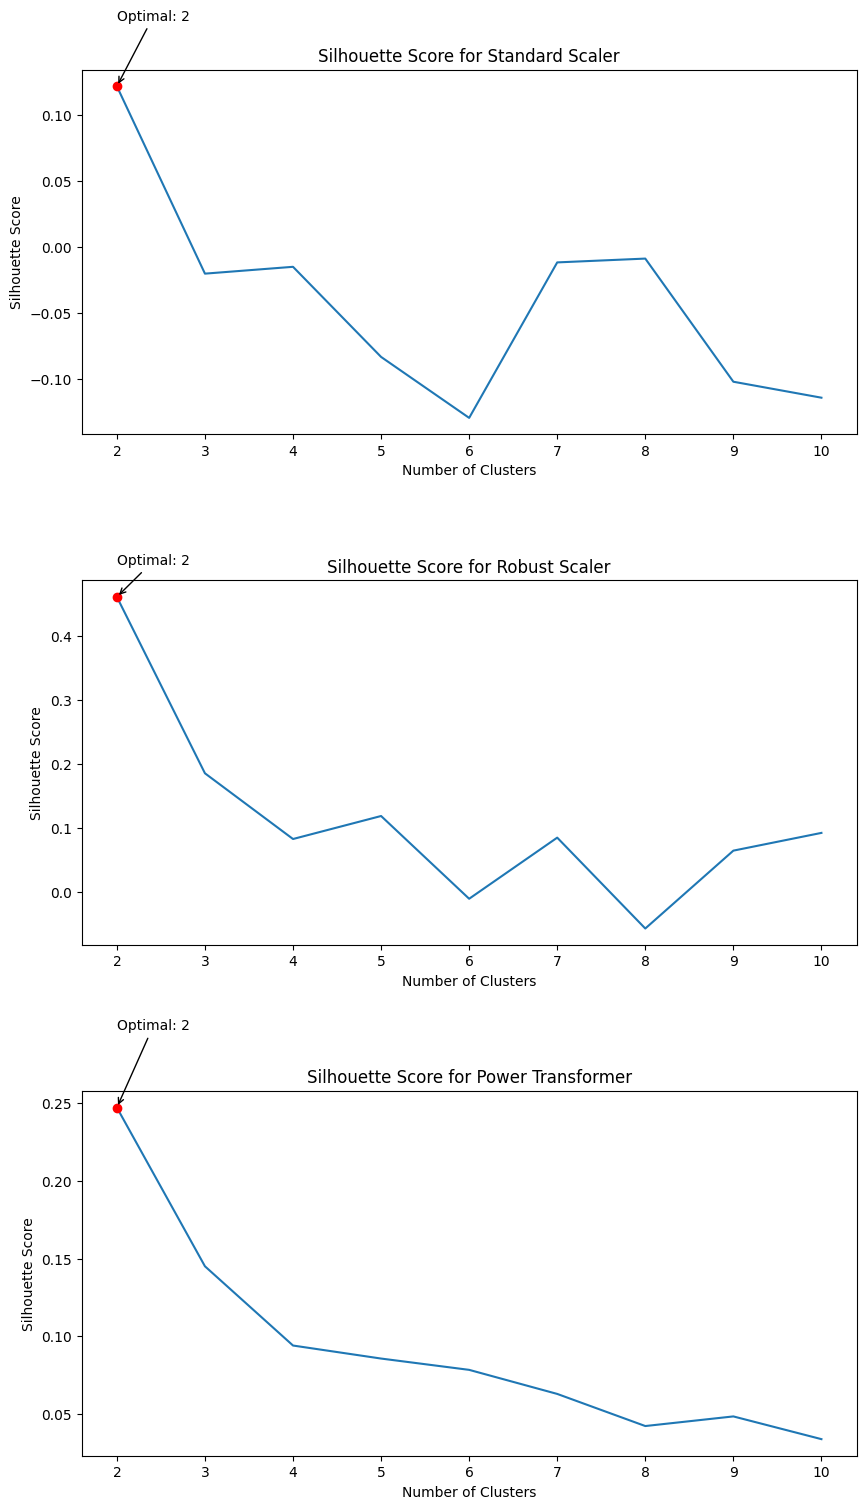

In [35]:
from sklearn.metrics import silhouette_score
from fcmeans import FCM


# Create subplots
fig, axes = plt.subplots(len(scaled_datasets), figsize=(10, 6 * len(scaled_datasets)))

# Iterate over the scaled datasets
for i, (scaler_name, data) in enumerate(scaled_datasets.items()):
    silhouette_scores = []
    for n_clusters in range(2, 11):
        fcm = FCM(n_clusters=n_clusters)
        fcm.fit(data)
        labels = fcm.u.argmax(axis=1)

        silhouette_scores.append(silhouette_score(data, labels))

    # Silhouette Score
    ax = axes[i]
    ax.plot(range(2, 11), silhouette_scores)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Silhouette Score for {scaler_name}')

    # Optimale Anzahl der Cluster
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

    ax.plot(optimal_clusters, max(silhouette_scores), 'ro')
    ax.annotate(f'Optimal: {optimal_clusters}',
                xy=(optimal_clusters, max(silhouette_scores)),
                xytext=(optimal_clusters, max(silhouette_scores) + 0.05),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.subplots_adjust(hspace=0.4)
plt.show()

## Clustering

### Fuzzy-c-means Clustering

Results for Standard Scaler:
   customer_id  cluster_0  cluster_1  cluster_2  cluster_3
0            0   0.250003   0.250014   0.250002   0.249981
1            1   0.249999   0.249986   0.250000   0.250015
2            2   0.250004   0.250003   0.250004   0.249989
3            3   0.250007   0.249960   0.250019   0.250015
4            4   0.249975   0.249978   0.249988   0.250058



Results for Robust Scaler:
   customer_id  cluster_0  cluster_1  cluster_2  cluster_3
0            0   0.552211   0.167534   0.140113   0.140142
1            1   0.048496   0.249061   0.351263   0.351180
2            2   0.021239   0.249042   0.364804   0.364914
3            3   0.013758   0.176938   0.404712   0.404592
4            4   0.013465   0.157801   0.414499   0.414234



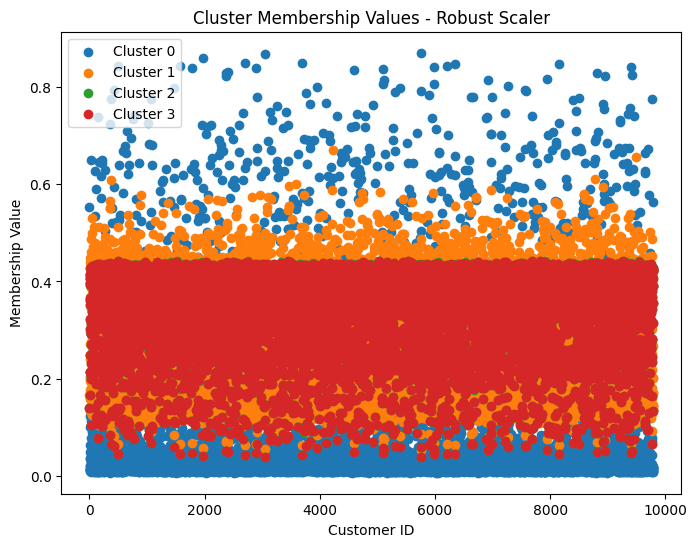

Results for Power Transformer:
   customer_id  cluster_0  cluster_1  cluster_2  cluster_3
0            0   0.480437   0.178509   0.217596   0.123457
1            1   0.135001   0.281905   0.239119   0.343975
2            2   0.208477   0.280970   0.292849   0.217704
3            3   0.091310   0.362385   0.275071   0.271234
4            4   0.085892   0.335754   0.240437   0.337917



In [36]:
from skfuzzy.cluster import cmeans
import pandas as pd


# fuzzy c-means Für alle 3 Datasets
cluster_results = []
scaler_names = ['Standard Scaler', 'Robust Scaler', 'Power Transformer']

for scaler_name, scaled_data in zip(scaler_names, [standard_scaled_pca, robust_scaled_pca, power_transformer_scaled_pca]):
    cntr, u, u0, d, jm, p, fpc = cmeans(scaled_data.T, 4, 2, error=0.005, maxiter=1000)

    # Create a DataFrame with membership values for each customer and each cluster
    membership_df = pd.DataFrame(u.T, columns=[f'cluster_{i}' for i in range(4)])
    membership_df['customer_id'] = non_outliers_df.index
    membership_df = membership_df[['customer_id'] + [f'cluster_{i}' for i in range(4)]]

    cluster_results.append((scaler_name, membership_df))

# Summarize and visualize the results
for scaler_name, membership_df in cluster_results:
    print(f"Results for {scaler_name}:")
    print(membership_df.head())
    print()

    # Plotting membership values
    plt.figure(figsize=(8, 6))
    for cluster in range(4):
        plt.scatter(membership_df['customer_id'], membership_df[f'cluster_{cluster}'], label=f'Cluster {cluster}')
    plt.xlabel('Customer ID')
    plt.ylabel('Membership Value')
    plt.title(f'Cluster Membership Values - {scaler_name}')
    plt.legend()
    plt.show()

In [37]:
membership_df.head()

customer_id  cluster_0  cluster_1  cluster_2  cluster_3
0            0   0.480437   0.178509   0.217596   0.123457
1            1   0.135001   0.281905   0.239119   0.343975
2            2   0.208477   0.280970   0.292849   0.217704
3            3   0.091310   0.362385   0.275071   0.271234
4            4   0.085892   0.335754   0.240437   0.337917

## Meanshift

Anzahl der Clusters für  Standard Scaler : 6


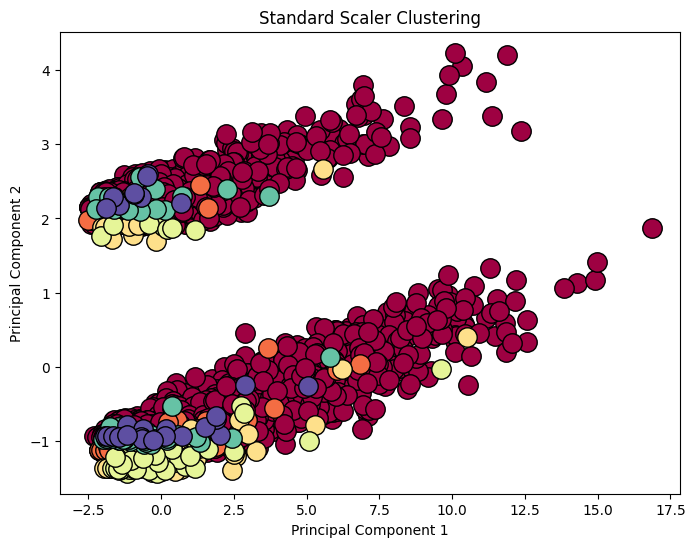

Anzahl in jedem Cluster:  [8913   75   68   52   51   29]
Anzahl der Clusters für  Robust Scaler : 1


Anzahl in jedem Cluster:  [9188]
Anzahl der Clusters für  Power Transformer Scaler : 1


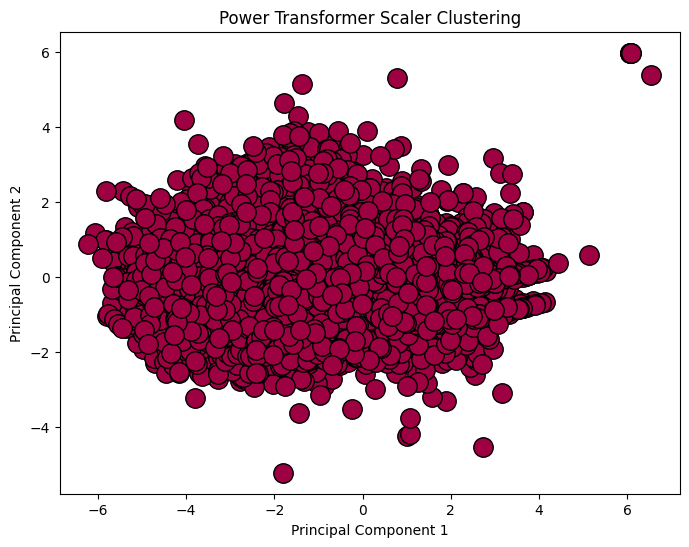

Anzahl in jedem Cluster:  [9188]


In [38]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np


# Mean Shift Funktion
def mean_shift_clustering(data, title):
    bandwidth = estimate_bandwidth(data, quantile=0.9, n_samples=1000)

    # Initialisierung und Fitting
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data)

    # labels 
    labels = ms.labels_

    # Zentroid Berechnen
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)

    # Anzahl der Clustern in Labels, Noise wird ignoriert
    n_clusters_ = len(labels_unique)

    print("Anzahl der Clusters für ", title, ":", n_clusters_)

    # Visualisierung
    unique_labels = np.unique(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure(figsize=(8, 6))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    plt.title(title + " Clustering")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()
    counts = np.bincount(labels[labels>=0])  # exclude noise (if any)
    print("Anzahl in jedem Cluster: ", counts)

# Mean Shift Funktionaufruf für alle 3 Datensätze
mean_shift_clustering(standard_scaled_pca, "Standard Scaler")
mean_shift_clustering(robust_scaled_pca, "Robust Scaler")
mean_shift_clustering(power_transformer_scaled_pca, "Power Transformer Scaler")

## DBSCAN CLustering

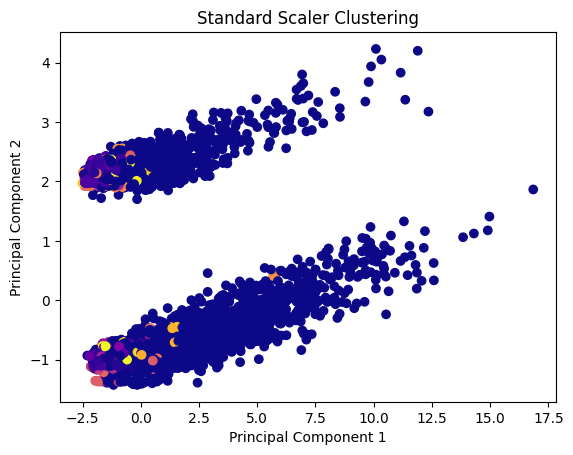

Anzahl der Cluster für  Standard Scaler : 498
Anzahl der Daten in Cluster:  {0: 248, 1: 61, 2: 6, 3: 2, 4: 39, 5: 2, 6: 8, 7: 158, 8: 24, 9: 37, 10: 3, 11: 5, 12: 17, 13: 2, 14: 2, 15: 103, 16: 26, 17: 2, 18: 48, 19: 43, 20: 12, 21: 245, 22: 72, 23: 83, 24: 54, 25: 2, 26: 2, 27: 21, 28: 13, 29: 157, 30: 34, 31: 67, 32: 29, 33: 15, 34: 2, 35: 2, 36: 107, 37: 53, 38: 29, 39: 15, 40: 3, 41: 3, 42: 71, 43: 30, 44: 122, 45: 14, 46: 2, 47: 58, 48: 203, 49: 18, 50: 4, 51: 53, 52: 11, 53: 2, 54: 4, 55: 8, 56: 2, 57: 3, 58: 10, 59: 4, 60: 7, 61: 39, 62: 10, 63: 44, 64: 9, 65: 2, 66: 2, 67: 73, 68: 20, 69: 8, 70: 3, 71: 3, 72: 3, 73: 2, 74: 2, 75: 36, 76: 2, 77: 2, 78: 5, 79: 9, 80: 2, 81: 71, 82: 3, 83: 3, 84: 5, 85: 22, 86: 3, 87: 2, 88: 3, 89: 24, 90: 2, 91: 15, 92: 8, 93: 2, 94: 2, 95: 32, 96: 30, 97: 10, 98: 5, 99: 3, 100: 6, 101: 2, 102: 25, 103: 3, 104: 4, 105: 6, 106: 2, 107: 2, 108: 2, 109: 14, 110: 18, 111: 3, 112: 2, 113: 13, 114: 3, 115: 2, 116: 27, 117: 2, 118: 24, 119: 2, 120: 12, 

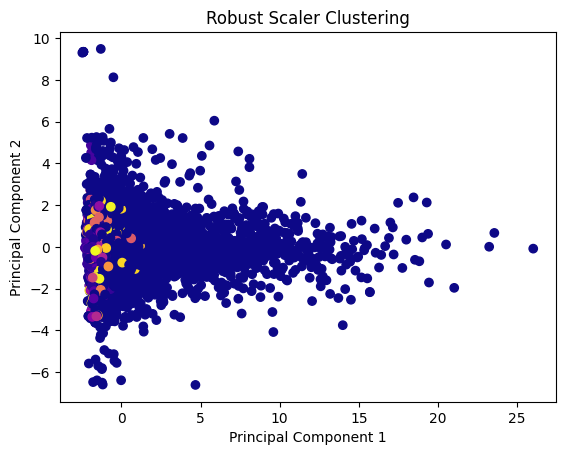

Anzahl der Cluster für  Robust Scaler : 594
Anzahl der Daten in Cluster:  {0: 43, 1: 44, 2: 3, 3: 2, 4: 26, 5: 6, 6: 92, 7: 17, 8: 32, 9: 33, 10: 3, 11: 4, 12: 16, 13: 2, 14: 126, 15: 16, 16: 22, 17: 29, 18: 12, 19: 7, 20: 8, 21: 179, 22: 60, 23: 62, 24: 11, 25: 13, 26: 44, 27: 24, 28: 2, 29: 2, 30: 8, 31: 12, 32: 144, 33: 15, 34: 23, 35: 11, 36: 2, 37: 58, 38: 47, 39: 4, 40: 14, 41: 2, 42: 2, 43: 17, 44: 22, 45: 116, 46: 54, 47: 9, 48: 15, 49: 3, 50: 19, 51: 50, 52: 189, 53: 18, 54: 4, 55: 67, 56: 5, 57: 5, 58: 6, 59: 2, 60: 2, 61: 4, 62: 2, 63: 2, 64: 2, 65: 9, 66: 4, 67: 6, 68: 34, 69: 9, 70: 2, 71: 11, 72: 2, 73: 40, 74: 2, 75: 2, 76: 57, 77: 18, 78: 3, 79: 3, 80: 2, 81: 27, 82: 2, 83: 3, 84: 2, 85: 5, 86: 2, 87: 4, 88: 3, 89: 21, 90: 4, 91: 3, 92: 2, 93: 21, 94: 2, 95: 2, 96: 18, 97: 2, 98: 7, 99: 6, 100: 2, 101: 3, 102: 2, 103: 2, 104: 28, 105: 3, 106: 29, 107: 4, 108: 8, 109: 3, 110: 4, 111: 24, 112: 2, 113: 2, 114: 2, 115: 6, 116: 16, 117: 2, 118: 14, 119: 3, 120: 2, 121: 2, 12

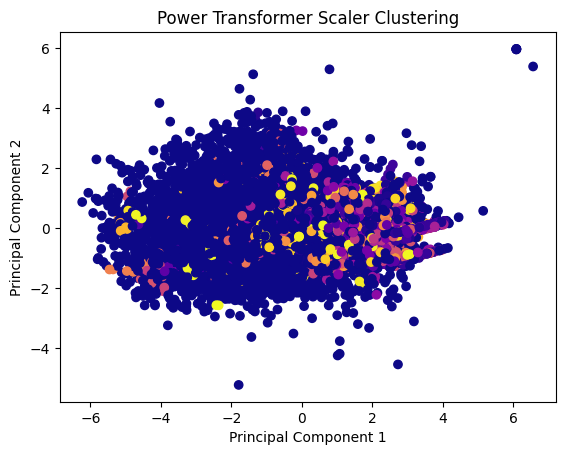

Anzahl der Cluster für  Power Transformer Scaler : 819
Anzahl der Daten in Cluster:  {0: 35, 1: 3, 2: 3, 3: 2, 4: 8, 5: 2, 6: 55, 7: 5, 8: 28, 9: 8, 10: 4, 11: 2, 12: 5, 13: 2, 14: 69, 15: 13, 16: 8, 17: 3, 18: 3, 19: 3, 20: 66, 21: 4, 22: 2, 23: 2, 24: 49, 25: 7, 26: 6, 27: 12, 28: 2, 29: 6, 30: 7, 31: 2, 32: 94, 33: 7, 34: 19, 35: 5, 36: 2, 37: 2, 38: 5, 39: 13, 40: 2, 41: 2, 42: 5, 43: 2, 44: 8, 45: 2, 46: 2, 47: 3, 48: 3, 49: 5, 50: 76, 51: 45, 52: 3, 53: 2, 54: 15, 55: 3, 56: 15, 57: 2, 58: 34, 59: 2, 60: 42, 61: 127, 62: 3, 63: 7, 64: 3, 65: 5, 66: 29, 67: 2, 68: 6, 69: 2, 70: 2, 71: 10, 72: 2, 73: 2, 74: 2, 75: 21, 76: 4, 77: 2, 78: 6, 79: 7, 80: 2, 81: 12, 82: 5, 83: 2, 84: 2, 85: 5, 86: 49, 87: 2, 88: 2, 89: 2, 90: 43, 91: 3, 92: 3, 93: 2, 94: 2, 95: 3, 96: 2, 97: 12, 98: 2, 99: 10, 100: 6, 101: 3, 102: 2, 103: 5, 104: 13, 105: 3, 106: 2, 107: 6, 108: 3, 109: 4, 110: 39, 111: 2, 112: 2, 113: 2, 114: 2, 115: 2, 116: 2, 117: 4, 118: 2, 119: 5, 120: 3, 121: 2, 122: 2, 123: 3, 124

In [39]:
from sklearn.cluster import DBSCAN
import numpy as np


#  DBSCAN Funktion
def dbscan_clustering(data, title):
    # Perform DBSCAN on the data
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    clusters = dbscan.fit_predict(data)

    # Plot
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap="plasma")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title + " Clustering")
    plt.show()

    # Anzahl der Element in jedem Cluster
    unique_labels, counts = np.unique(clusters[clusters != -1], return_counts=True)
    print("Anzahl der Cluster für ", title, ":", len(unique_labels))
    print("Anzahl der Daten in Cluster: ", dict(zip(unique_labels, counts)))

# Funktionsaufruf für alle 3 Datasets
dbscan_clustering(standard_scaled_pca, "Standard Scaler")
dbscan_clustering(robust_scaled_pca, "Robust Scaler")
dbscan_clustering(power_transformer_scaled_pca, "Power Transformer Scaler")


## Agglomeratives Clustering

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


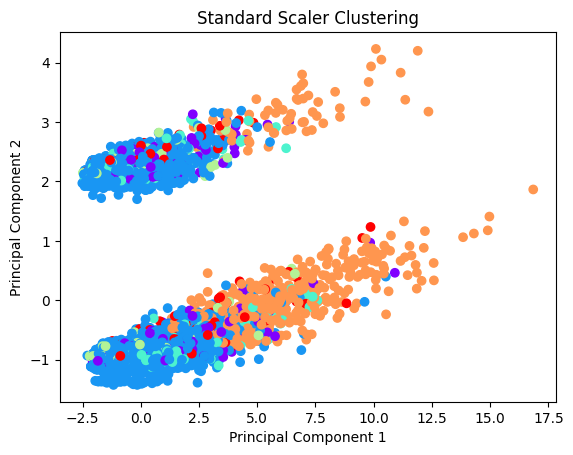

Anzahl der Cluster für  Standard Scaler : 6
Anzahl der Elementen je Cluster:  {0: 1001, 1: 6036, 2: 818, 3: 463, 4: 530, 5: 340}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


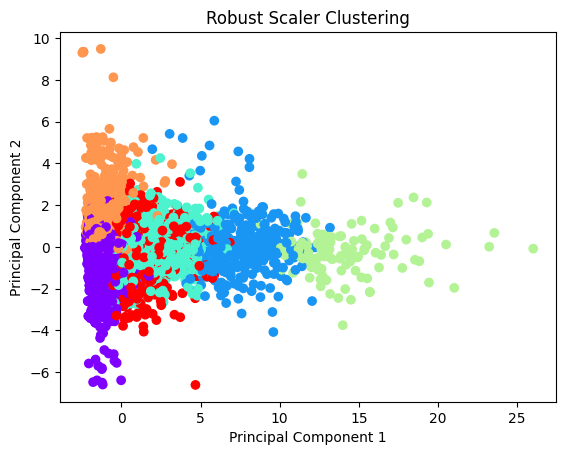

Anzahl der Cluster für  Robust Scaler : 6
Anzahl der Elementen je Cluster:  {0: 5220, 1: 411, 2: 1383, 3: 114, 4: 1214, 5: 846}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


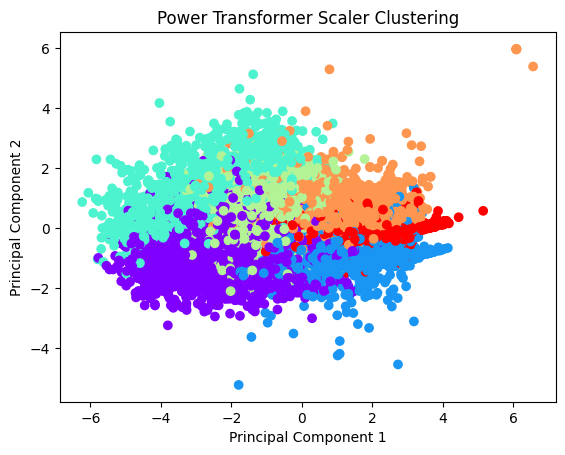

Anzahl der Cluster für  Power Transformer Scaler : 6
Anzahl der Elementen je Cluster:  {0: 1981, 1: 1487, 2: 904, 3: 1426, 4: 1939, 5: 1451}


In [40]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering and Visualisierung
def agglomerative_clustering(data, title):
    # Perform Agglomerative Clustering on the data
    cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
    labels = cluster.fit_predict(data)

    # Plot
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title + " Clustering")
    plt.show()

    # Anzahl der Element in jedem Cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Anzahl der Cluster für ", title, ":", len(unique_labels))
    print("Anzahl der Elementen je Cluster: ", dict(zip(unique_labels, counts)))

# Funktionsaufruf für alle 3 Datasets
agglomerative_clustering(standard_scaled_pca, "Standard Scaler")
agglomerative_clustering(robust_scaled_pca, "Robust Scaler")
agglomerative_clustering(power_transformer_scaled_pca, "Power Transformer Scaler")


## Hierarchische Clustering mit einer Dendogramme

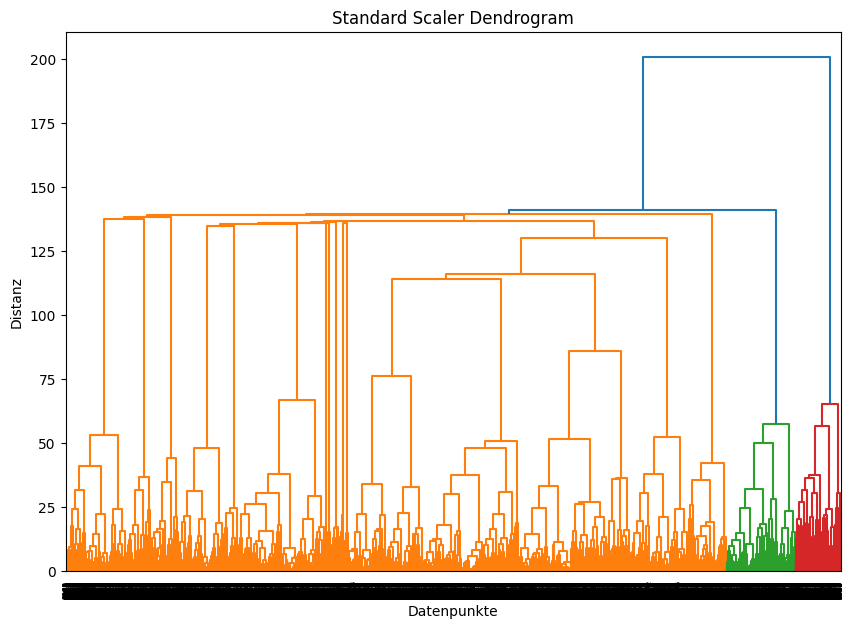

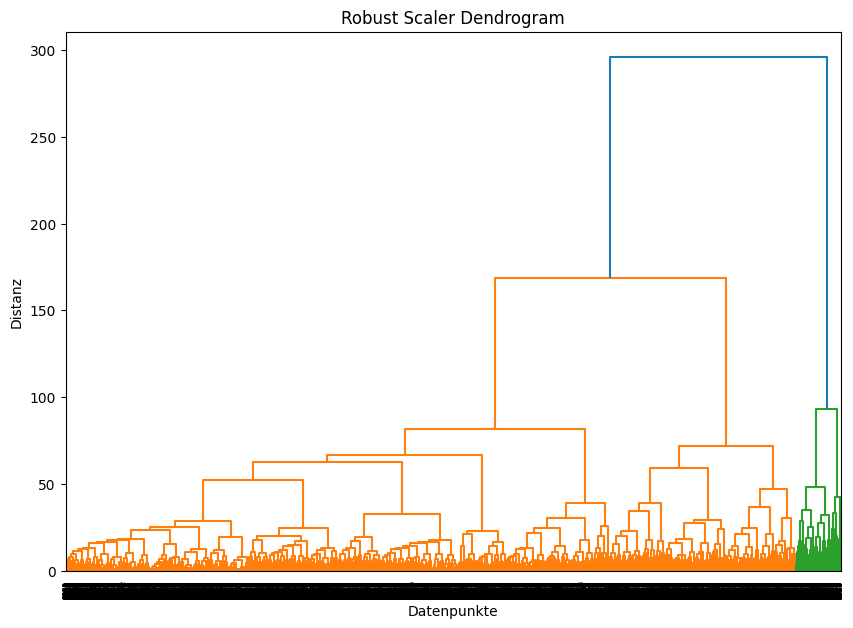

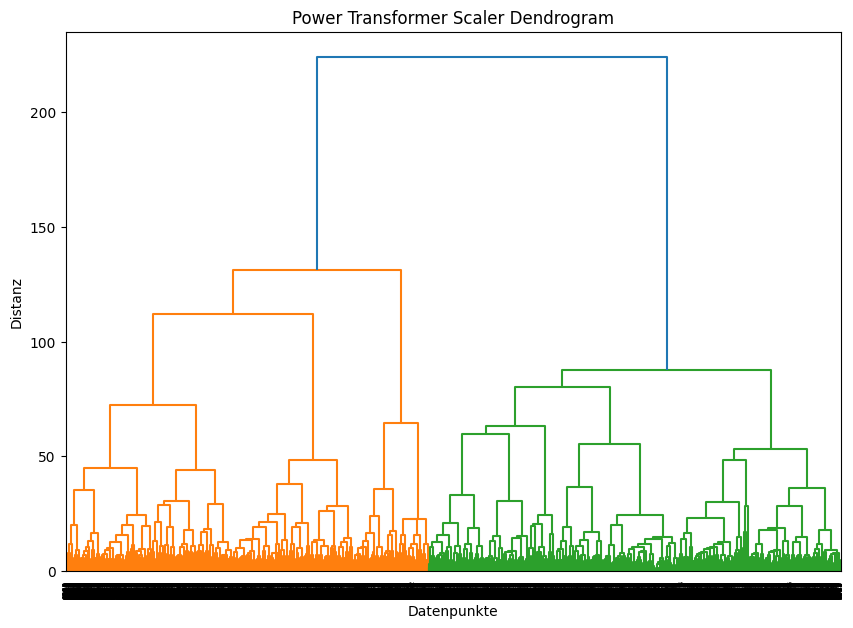

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Dendogramm erstellen
def create_dendrogram(data, title):
    # hierarchical clustering mit Ward's linkage
    linked = linkage(data, method='ward')

    # Plot
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title(title + " Dendrogram")
    plt.xlabel("Datenpunkte")
    plt.ylabel("Distanz")
    plt.show()

# Funktionsaufruf für alle 3 Datasets
create_dendrogram(standard_scaled_pca, "Standard Scaler")
create_dendrogram(robust_scaled_pca, "Robust Scaler")
create_dendrogram(power_transformer_scaled_pca, "Power Transformer Scaler")


## K-Means

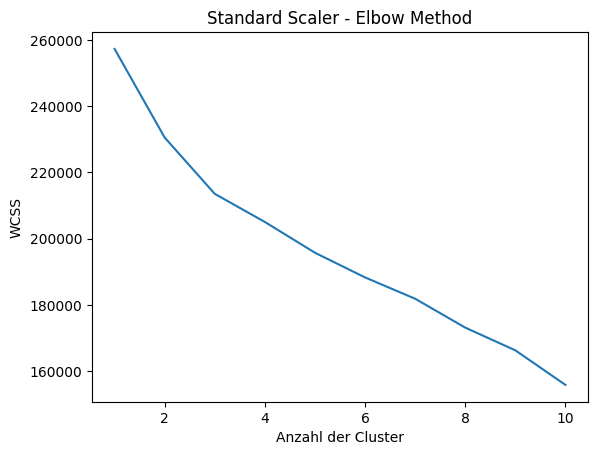

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


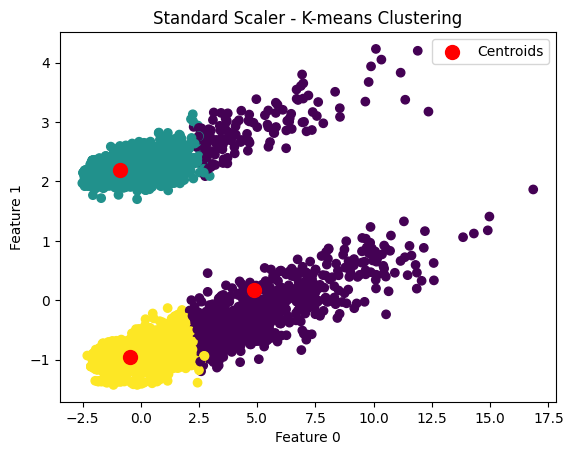

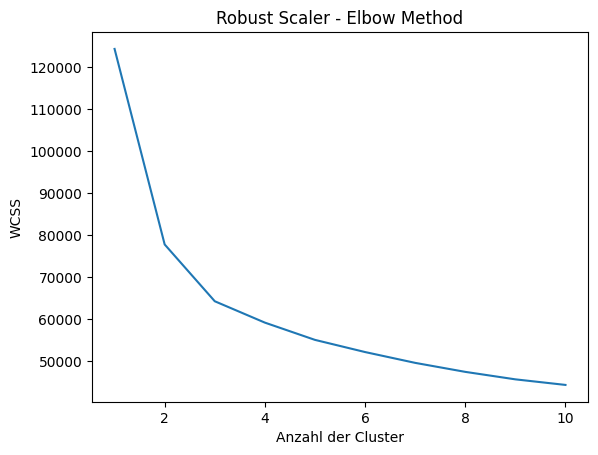

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


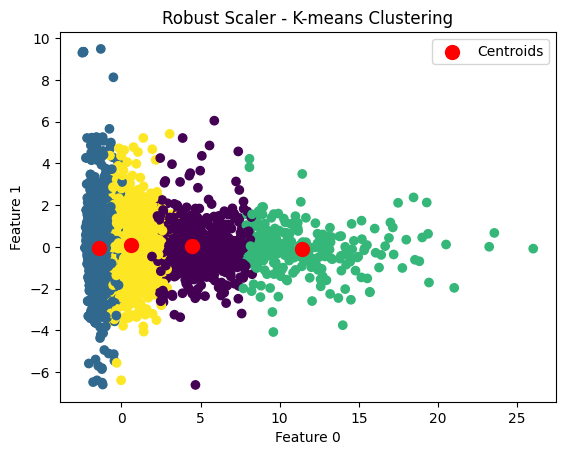

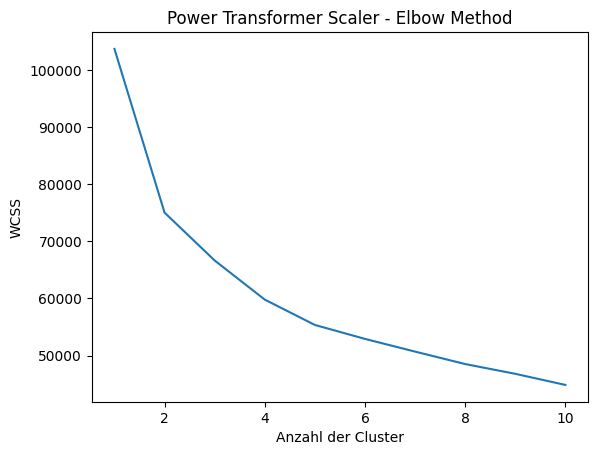

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


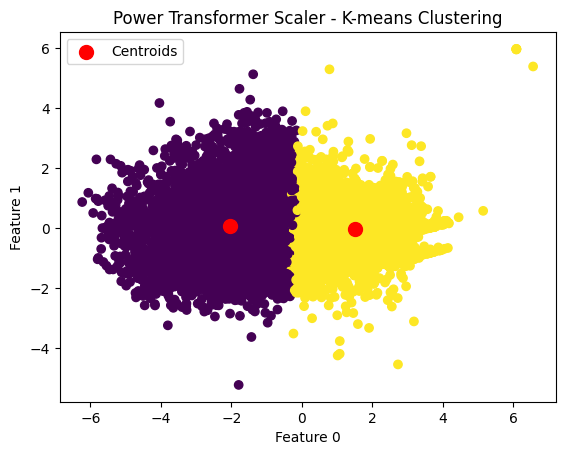

In [42]:
# Funktion für K-Means Clustering mit allen 3 Datasets und Visualisierung
def kmeans_clustering(data, cluster_amount, title):
    wcss = []

    # K-means clustering
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=0, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the within-cluster sum of squares (WCSS) to determine the optimal number of clusters
    plt.plot(range(1, 11), wcss)
    plt.title(title + ' - Elbow Method')
    plt.xlabel('Anzahl der Cluster')
    plt.ylabel('WCSS')
    plt.show()

    # K-means mit optimaler Anzahl der Clustern 
    kmeans = KMeans(n_clusters=cluster_amount, init='k-means++', max_iter=300, random_state=0)
    clusters = kmeans.fit_predict(data)

    # Visualisierung von Clustering
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', label='Centroids')
    plt.title(title + ' - K-means Clustering')
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.legend()
    plt.show()

# Perform K-means clustering and visualization for each scaled dataset
kmeans_clustering(standard_scaled_pca, 3, 'Standard Scaler')
kmeans_clustering(robust_scaled_pca,4, 'Robust Scaler')
kmeans_clustering(power_transformer_scaled_pca,2, 'Power Transformer Scaler')
